# Analysis and Downstream Tasks

This section runs all downstream analyses, including:
- TVD (Total Variation Distance) calculations  
- MSE and MAE error metrics  
- CellTypist cell type predictions  
- Differential expression analysis  


## 1. MSE and MAE error metrics

#### Compute bulk MAE/MSE between naive and ground truth and also predicted vs ground truth 

In [2]:
import scanpy as sc
import numpy as np

# --- Function Definitions ---
def calculate_mae(actual, predicted):
    """Calculate Mean Absolute Error (MAE) between two arrays."""
    return np.mean(np.abs(actual - predicted))

def calculate_mse(actual, predicted):
    """Calculate Mean Squared Error (MSE) between two arrays."""
    return np.mean((actual - predicted) ** 2)

def f(n_vals, j):
    """Transformation: f(n, 4^j)  4^j * (1 - (1 - 1/4^j)^n)."""
    return 4**j * (1 - (1 - 1 / 4**j)**n_vals)

i = 12  # Ground truth UMI length (adata_12)
j = 5   # UMI length for comparison


# Ground truth dataset (UMI length 12)
adata_12 = sc.read_h5ad("/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/adata_12.h5ad")
# adata_12 = sc.read_h5ad("/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ur_objects/adata_matrices/adata_12.h5ad")

# adata_12 = sc.read_h5ad("/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ur_objects/adata_matrices/adata_12.h5ad")
print("Ground Truth adata_12:")
print(adata_12)

# Inverted dataset for model approach (UMI lengths 1-12)
# model_dir = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ur_objects/inverted2_adata_matrices/"


model_dir  = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/"
# model_dir = "/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ur_objects/inverted2_adata_matrices/"
adata_dict_model = {idx: sc.read_h5ad(model_dir + f"adata_{idx}.h5ad") for idx in range(1, 13)}
print("Model Dataset (example adata_dict_model[6]):")
print(adata_dict_model[6])

# Naive dataset (UMI lengths 1-12)
naive_dir = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/"
# naive_dir = "/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ur_objects/adata_matrices/"
adata_dict_naive = {idx: sc.read_h5ad(naive_dir + f"adata_{idx}.h5ad") for idx in range(1, 13)}
print("Naive Dataset (example adata_dict_naive[6]):")
print(adata_dict_naive[6])

# --- Compute Bulk MAE for the Model Approach ---
# Use ground truth counts from adata_12 and predicted counts from the model (inverted) dataset at UMI length j.
all_true_model = []
all_pred_model = []

for barcode in adata_12.obs_names:
    if barcode in adata_dict_model[j].obs_names:
        idx_12 = np.where(adata_12.obs_names == barcode)[0][0]
        idx_j = np.where(adata_dict_model[j].obs_names == barcode)[0][0]
        
        # Extract ground truth counts from adata_12 and predicted counts from the model dataset
        gene_counts_12 = adata_12.X[idx_12].flatten()
        gene_counts_model = adata_dict_model[j].X[idx_j].flatten()
        
        # Only consider genes with counts ≥ 1 and adjust by adding 1 (for log scale)
        mask = gene_counts_12 >= 1
        true_counts = gene_counts_12[mask] 
        pred_counts = gene_counts_model[mask] 
        
        all_true_model.extend(true_counts)
        all_pred_model.extend(pred_counts)

all_true_model = np.array(all_true_model)
all_pred_model = np.array(all_pred_model)
bulk_mae_model = calculate_mae(all_true_model, all_pred_model)
bulk_mse_model = calculate_mse(all_true_model, all_pred_model)
# print("Bulk Model MAE (Ground Truth adata_12 vs. Inverted UMI 5):", bulk_mae_model)


# --- Compute Bulk MAE for the Naive Approach ---
# Use ground truth counts from adata_12 and predicted counts from the naive dataset at UMI length j.
all_true_naive = []
all_naive_pred = []

for barcode in adata_12.obs_names:
    if barcode in adata_dict_naive[j].obs_names:
        idx_12 = np.where(adata_12.obs_names == barcode)[0][0]
        idx_j = np.where(adata_dict_naive[j].obs_names == barcode)[0][0]
        
        # Extract ground truth counts from adata_12 and predicted counts from the naive dataset
        gene_counts_12 = adata_12.X[idx_12].flatten()
        gene_counts_naive = adata_dict_naive[j].X[idx_j].flatten()
        
        # Only consider genes with counts ≥ 1 and adjust by adding 1 (for log scale)
        mask = gene_counts_12 >= 1
        true_counts = gene_counts_12[mask] 
        naive_counts = gene_counts_naive[mask] 
        
        all_true_naive.extend(true_counts)
        all_naive_pred.extend(naive_counts)

all_true_naive = np.array(all_true_naive)
all_naive_pred = np.array(all_naive_pred)
bulk_mae_naive = calculate_mae(all_true_naive, all_naive_pred)
bulk_mse_naive = calculate_mse(all_true_naive, all_naive_pred)


print("Bulk Naive MAE (Ground Truth adata_12 vs. Naive UMI 5):", bulk_mae_naive)
print("Bulk Model MAE (Ground Truth adata_12 vs. Inverted UMI 5):", bulk_mae_model)
percent_change = (bulk_mae_naive - bulk_mae_model)/ bulk_mae_naive
print("Percent Change", percent_change * 100)
print("=======================================================================")

print("Bulk Naive MSE (Ground Truth adata_12 vs. Naive UMI 5):", bulk_mse_naive)
print("Bulk Model MSE (Ground Truth adata_12 vs. Inverted UMI 5):", bulk_mse_model)
percent_change = (bulk_mse_naive - bulk_mse_model)/ bulk_mse_naive 
print("Percent Change", percent_change * 100)


Ground Truth adata_12:
AnnData object with n_obs × n_vars = 1232 × 28226
Model Dataset (example adata_dict_model[6]):
AnnData object with n_obs × n_vars = 1232 × 28226
Naive Dataset (example adata_dict_naive[6]):
AnnData object with n_obs × n_vars = 1232 × 28226
Bulk Naive MAE (Ground Truth adata_12 vs. Naive UMI 5): 0.10638695235109294
Bulk Model MAE (Ground Truth adata_12 vs. Inverted UMI 5): 0.05002175747142818
Percent Change 52.98130422389688
Bulk Naive MSE (Ground Truth adata_12 vs. Naive UMI 5): 155.43933026750406
Bulk Model MSE (Ground Truth adata_12 vs. Inverted UMI 5): 7.384367536213194
Percent Change 95.24935708130945


#### Per-cell MAE and MSE: Naïve vs Model (scatter comparison)

Ground Truth adata_12:
AnnData object with n_obs × n_vars = 1232 × 28226
Model Dataset (inverted), example adata_dict_model[6]:
AnnData object with n_obs × n_vars = 1232 × 28226
Naive Dataset, example adata_dict_naive[6]:
AnnData object with n_obs × n_vars = 1232 × 28226
Per-cell Model MAE Vector:
[0.04241276 0.034528   0.02913269 ... 0.03987178 0.03798206 0.03595877]
Per-cell Model MSE Vector:
[0.08315598 0.09229154 0.07698606 ... 0.34494497 0.07738931 0.05792321]
Per-cell Naive MAE Vector:
[0.06495726 0.04389258 0.03994294 ... 0.05747532 0.05554296 0.04065621]
Per-cell Naive MSE Vector:
[0.61733822 0.56020791 0.82239658 ... 1.95803949 0.4676944  0.2211127 ] 1232
Percent of cells where MSE_Model is better than Naive: 99.43%


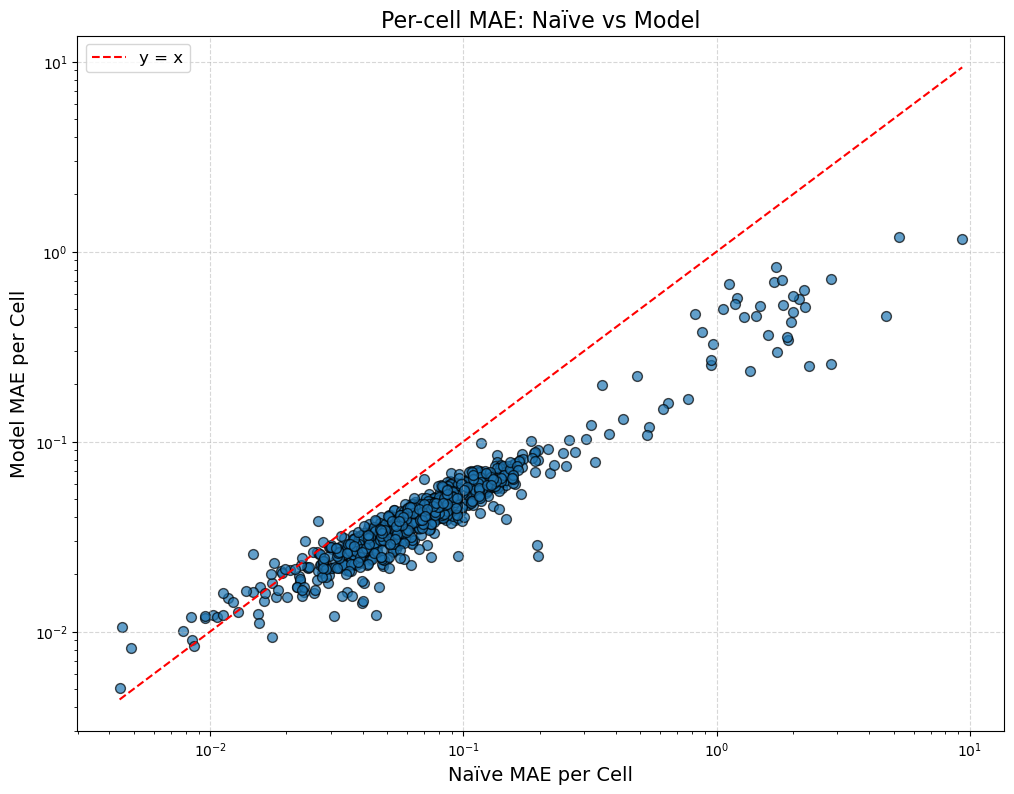

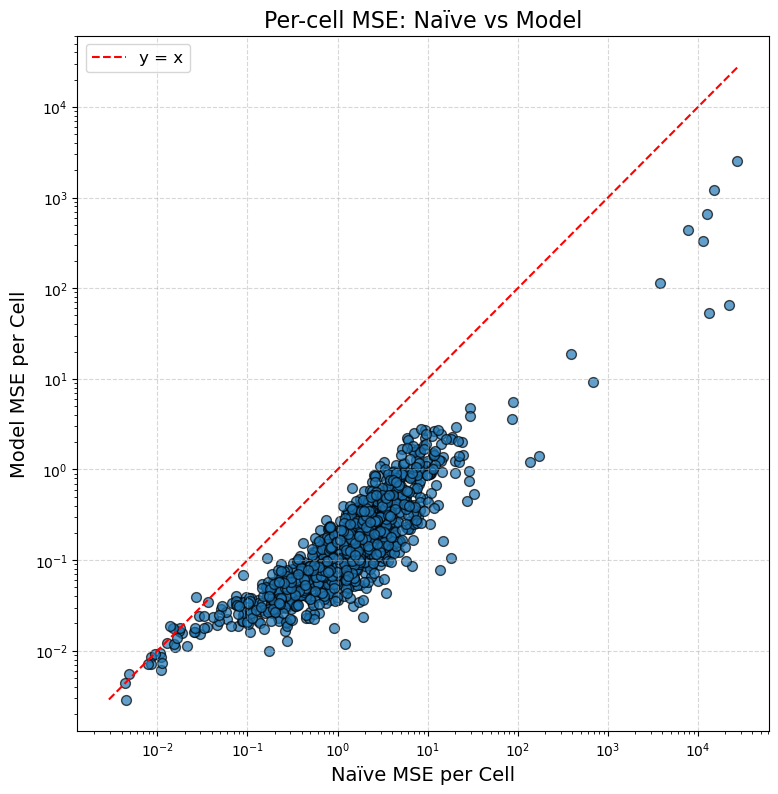

In [3]:
import scanpy as sc
import numpy as np

# --- Function Definitions ---
def calculate_mae(actual, predicted):
    """Calculate Mean Absolute Error (MAE) between two arrays."""
    return np.mean(np.abs(actual - predicted))

def calculate_mse(actual, predicted):
    """Calculate Mean Squared Error (MSE) between two arrays."""
    return np.mean((actual - predicted) ** 2)

def f(n_vals, j):
    """Transformation: f(n, 4^j) = 4^j * (1 - (1 - 1/4^j)^n)."""
    return 4**j * (1 - (1 - 1 / 4**j)**n_vals)

# --- Parameters ---
i = 12  # UMI length for ground truth
j = 5   # UMI length for comparison

# --- Load Datasets ---
# Ground truth dataset (UMI length 12)
adata_12 = sc.read_h5ad("/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/adata_12.h5ad") #1k
# adata_12 = sc.read_h5ad("/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ur_objects/adata_matrices/adata_12.h5ad") #10k
print("Ground Truth adata_12:")
print(adata_12)

# Inverted dataset for model MAE and MSE (UMI lengths 1-12)
model_dir  = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/"
# model_dir = "/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ur_objects/inverted2_adata_matrices/" #10k
adata_dict_model = {idx: sc.read_h5ad(model_dir + f"adata_{idx}.h5ad") for idx in range(1, 13)}
print("Model Dataset (inverted), example adata_dict_model[6]:")
print(adata_dict_model[6])

# Naive dataset (UMI lengths 1-12)
# naive_dir = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/" #1k
# naive_dir = "/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ur_objects/adata_matrices/" # 10k
adata_dict_naive = {idx: sc.read_h5ad(naive_dir + f"adata_{idx}.h5ad") for idx in range(1, 13)}
print("Naive Dataset, example adata_dict_naive[6]:")
print(adata_dict_naive[6])

# --- Compute Per-cell MAE for the Model Approach ---
mae_model_vector = []
for barcode in adata_12.obs_names:
    if barcode in adata_dict_model[j].obs_names:
        idx_12 = np.where(adata_12.obs_names == barcode)[0][0]
        idx_j = np.where(adata_dict_model[j].obs_names == barcode)[0][0]
        gene_counts_12 = adata_12.X[idx_12].flatten()
        gene_counts_j = adata_dict_model[j].X[idx_j].flatten()
        mask = gene_counts_12 >= 1
        true_counts = gene_counts_12[mask] + 1  # Adjust for log scale
        predicted_counts = gene_counts_j[mask] + 1  # Adjust for log scale
        
        mae_model_vector.append(calculate_mae(true_counts, predicted_counts))
mae_model_vector = np.array(mae_model_vector)
print("Per-cell Model MAE Vector:")
print(mae_model_vector)

# --- Compute Per-cell MSE for the Model Approach ---
mse_model_vector = []
for barcode in adata_12.obs_names:
    if barcode in adata_dict_model[j].obs_names:
        idx_12 = np.where(adata_12.obs_names == barcode)[0][0]
        idx_j = np.where(adata_dict_model[j].obs_names == barcode)[0][0]
        gene_counts_12 = adata_12.X[idx_12].flatten()
        gene_counts_j = adata_dict_model[j].X[idx_j].flatten()
        mask = gene_counts_12 >= 1
        true_counts = gene_counts_12[mask] + 1  # Adjust for log scale
        predicted_counts = gene_counts_j[mask] + 1  # Adjust for log scale
        
        mse_model_vector.append(calculate_mse(true_counts, predicted_counts))
mse_model_vector = np.array(mse_model_vector)
print("Per-cell Model MSE Vector:")
print(mse_model_vector)

# --- Compute Per-cell MAE for the Naive Approach ---
naive_mae_vector = []
for barcode in adata_dict_naive[i].obs_names:
    if barcode in adata_dict_naive[j].obs_names:
        idx_i = np.where(adata_dict_naive[i].obs_names == barcode)[0][0]
        idx_j = np.where(adata_dict_naive[j].obs_names == barcode)[0][0]
        gene_counts_i = adata_dict_naive[i].X[idx_i].flatten()
        gene_counts_j = adata_dict_naive[j].X[idx_j].flatten()
        mask = gene_counts_i >= 1
        true_counts = gene_counts_i[mask] + 1  # Adjust for log scale
        naive_counts = gene_counts_j[mask] + 1  # Adjust for log scale
        naive_mae_vector.append(calculate_mae(true_counts, naive_counts))
naive_mae_vector = np.array(naive_mae_vector)
print("Per-cell Naive MAE Vector:")
print(naive_mae_vector)

# --- Compute Per-cell MSE for the Naive Approach ---
naive_mse_vector = []
for barcode in adata_dict_naive[i].obs_names:
    if barcode in adata_dict_naive[j].obs_names:
        idx_i = np.where(adata_dict_naive[i].obs_names == barcode)[0][0]
        idx_j = np.where(adata_dict_naive[j].obs_names == barcode)[0][0]
        gene_counts_i = adata_dict_naive[i].X[idx_i].flatten()
        gene_counts_j = adata_dict_naive[j].X[idx_j].flatten()
        mask = gene_counts_i >= 1
        true_counts = gene_counts_i[mask] + 1  # Adjust for log scale
        naive_counts = gene_counts_j[mask] + 1  # Adjust for log scale
        naive_mse_vector.append(calculate_mse(true_counts, naive_counts))
naive_mse_vector = np.array(naive_mse_vector)
print("Per-cell Naive MSE Vector:")
print(naive_mse_vector, len(naive_mse_vector))


# --- Calculate Percent of Cells where MSE_Model is Better than MSE_Naive ---
better_model_count = np.sum(mse_model_vector < naive_mse_vector)
total_cells = len(mse_model_vector)
percent_better_model = (better_model_count / total_cells) * 100

print(f"Percent of cells where MSE_Model is better than Naive: {percent_better_model:.2f}%")




import matplotlib.pyplot as plt

# --- MAE Plot ---
plt.figure(figsize=(10, 10))
plt.scatter(naive_mae_vector, mae_model_vector, alpha=0.7, edgecolor='k', s=50)
plt.xlabel("Naïve MAE per Cell", fontsize=14)
plt.ylabel("Model MAE per Cell", fontsize=14)
plt.title("Per-cell MAE: Naïve vs Model", fontsize=16)

# Identity line for reference
min_val = min(naive_mae_vector.min(), mae_model_vector.min())
max_val = max(naive_mae_vector.max(), mae_model_vector.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='y = x')
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.xscale('log')
plt.yscale('log')

# Save the MAE plot image
# plt.savefig("/data/dagyeman/cellranger/bam_file_analysis/figures_ur/mae_mse_plots/1k_per_cell_mae_naive_vs_model.pdf")
# plt.savefig("/data/dagyeman/cellranger/bam_file_analysis/figures_ur/10k_PBMCs/mae_mse_plots/10k_per_cell_mae_naive_vs_model.pdf")
plt.show()

# --- MSE Plot ---
plt.figure(figsize=(10, 10))
plt.scatter(naive_mse_vector, mse_model_vector, alpha=0.7, edgecolor='k', s=50)
plt.xlabel("Naïve MSE per Cell", fontsize=14)
plt.ylabel("Model MSE per Cell", fontsize=14)
plt.title("Per-cell MSE: Naïve vs Model", fontsize=16)

# Identity line for reference
min_val = min(naive_mse_vector.min(), mse_model_vector.min())
max_val = max(naive_mse_vector.max(), mse_model_vector.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='y = x')
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.xscale('log')
plt.yscale('log')

# Save the MSE plot image
# plt.savefig("/data/dagyeman/cellranger/bam_file_analysis/figures_ur/mae_mse_plots/1k_per_cell_mse_naive_vs_model.pdf")
# plt.savefig("/data/dagyeman/cellranger/bam_file_analysis/figures_ur/10k_PBMCs/mae_mse_plots/10k_per_cell_mse_naive_vs_model.pdf")
plt.show()


## 2. TVD

### ONly using Means

#### All genes, SSE

[1.7245899503485906e-07, 1.1394019525718372e-07, 5.950915998878995e-08, 2.6144156324145658e-08, 1.2483041863840777e-08, 4.4384495548850904e-09, 7.296868210362753e-10, 7.330280496592718e-11, 1.2916836257210385e-11, 6.253265747561655e-12, 2.3455136169407872e-12, 0.0]
[1.4842248912162102e-07, 6.55639076670343e-08, 2.076986955660929e-08, 8.368405914329241e-09, 6.081605729829154e-10, 1.1227776552185034e-10, 3.2733405897163764e-11, 1.495608718223771e-11, 9.643037568326622e-12, 6.239361397271049e-12, 2.3689626895465547e-12, 1.2160434141554506e-15]
[1.4634008668930267e-07, 6.699899886873933e-08, 2.1756224415891538e-08, 1.0063862962366486e-08, 1.6808649815704892e-09, 3.863250395536436e-10, 7.309096462090327e-11, 1.7830956235260193e-11, 9.677375479865708e-12, 6.193017313345779e-12, 2.3593400854071813e-12, 0.0]


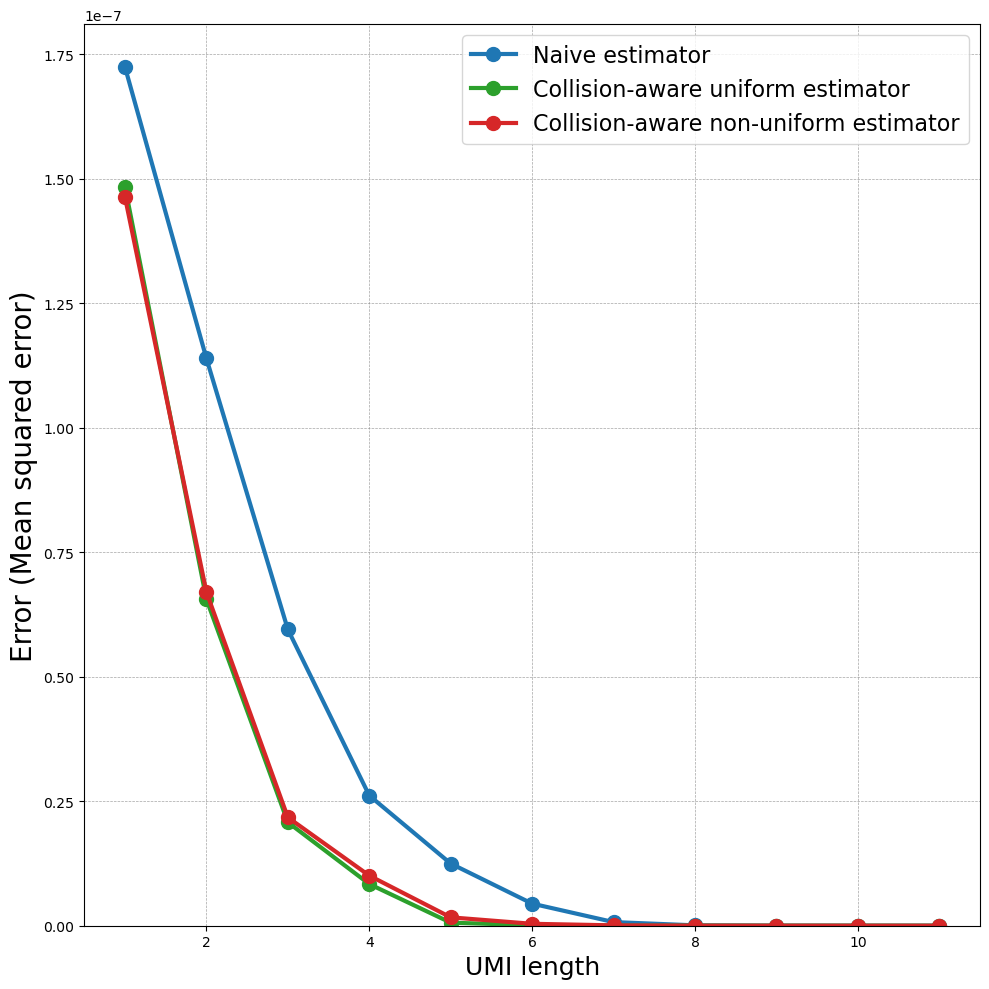

In [11]:
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt

def sse(p, q):
    """
    Calculate the Mean Squared Error (MSE) between two vectors p and q.
    Assumes that p and q are numpy arrays with the same length.
    """
    p = np.array(p, dtype=np.float64)
    q = np.array(q, dtype=np.float64)
    
    # Check for NaN or infinite values in p and q
    if np.isnan(p).any() or np.isinf(p).any():
        raise ValueError("Input array p contains NaN or infinite values.")
    if np.isnan(q).any() or np.isinf(q).any():
        raise ValueError("Input array q contains NaN or infinite values.")
    
    # Check if sums are zero to avoid division by zero in normalization
    sum_p = np.sum(p)
    sum_q = np.sum(q)
    if sum_p == 0 or sum_q == 0:
        raise ValueError("Sum of the input arrays should not be zero.")
    
    # Ensure both vectors are normalized
    p = p / sum_p
    q = q / sum_q
    
    # Compute the Mean Squared Error
    return np.sum((p - q) ** 2)

# Loading the regular adata matrices
common_path = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices"
regular_adata_dict = {}
for i in range(1, 13):
    path = f"{common_path}/adata_{i}.h5ad"
    regular_adata_dict[i] = sc.read_h5ad(path)

# Loading the collision-aware uniform matrices
common_path2 = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/col_aware_unif_matrices"
unif_adata_dict = {}
for i in range(1, 13):
    path = f"{common_path2}/adata_{i}.h5ad"
    unif_adata_dict[i] = sc.read_h5ad(path)
    
# Loading the collision-aware non-uniform matrices
common_path3 = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/col_aware_nunif_matrices"
non_unif_adata_dict = {}
for i in range(1, 12):
    path = f"{common_path3}/adata_{i}.h5ad"
    non_unif_adata_dict[i] = sc.read_h5ad(path)
non_unif_adata_dict[12] = sc.read_h5ad(f"{common_path}/adata_12.h5ad")

# This is the ground truth adata matrix
gt_adata12 = regular_adata_dict[12]

# Initialize lists to store the mean errors
mean_errors, mean_errors2, mean_errors3 = [], [], []

# Compute MSE (on row-normalized vectors) for regular and inverted matrices against the ground truth
for i in range(1, 13):
    # --- Regular vs GT ---
    common_cells = [c for c in gt_adata12.obs_names if c in regular_adata_dict[i].obs_names]
    common_genes = [g for g in gt_adata12.var_names if g in regular_adata_dict[i].var_names]
    reg_mat = regular_adata_dict[i][common_cells, common_genes].X
    gt_mat  = gt_adata12[common_cells, common_genes].X
    reg_mat = reg_mat.toarray() if hasattr(reg_mat, "toarray") else np.asarray(reg_mat)
    gt_mat  = gt_mat.toarray()  if hasattr(gt_mat,  "toarray") else np.asarray(gt_mat)
    reg_mat = reg_mat.astype(np.float64, copy=False)
    gt_mat  = gt_mat.astype(np.float64, copy=False)
    mask = (gt_mat >= 1.0)
    reg_mat = reg_mat * mask
    gt_mat  = gt_mat  * mask
    sum_reg = reg_mat.sum(axis=1, keepdims=True)
    sum_gt  = gt_mat.sum(axis=1, keepdims=True)
    reg_norm = reg_mat / sum_reg
    gt_norm  = gt_mat  / sum_gt
    per_row_mse = np.mean((reg_norm - gt_norm) ** 2, axis=1)
    mean_errors.append(float(np.mean(per_row_mse)))

    # --- Uniform inverted vs GT ---
    common_cells = [c for c in gt_adata12.obs_names if c in unif_adata_dict[i].obs_names]
    common_genes = [g for g in gt_adata12.var_names if g in unif_adata_dict[i].var_names]
    unif_mat = unif_adata_dict[i][common_cells, common_genes].X
    gt_mat   = gt_adata12[common_cells, common_genes].X
    unif_mat = unif_mat.toarray() if hasattr(unif_mat, "toarray") else np.asarray(unif_mat)
    gt_mat   = gt_mat.toarray()   if hasattr(gt_mat,  "toarray") else np.asarray(gt_mat)
    unif_mat = unif_mat.astype(np.float64, copy=False)
    gt_mat   = gt_mat.astype(np.float64, copy=False)
    mask = (gt_mat >= 1.0)
    unif_mat = unif_mat * mask
    gt_mat   = gt_mat   * mask
    sum_unif = unif_mat.sum(axis=1, keepdims=True)
    sum_gt   = gt_mat.sum(axis=1, keepdims=True)
    unif_norm = unif_mat / sum_unif
    gt_norm   = gt_mat  / sum_gt
    per_row_mse2 = np.mean((unif_norm - gt_norm) ** 2, axis=1)
    mean_errors2.append(float(np.mean(per_row_mse2)))

    # --- Non-uniform inverted vs GT ---
    common_cells = [c for c in gt_adata12.obs_names if c in non_unif_adata_dict[i].obs_names]
    common_genes = [g for g in gt_adata12.var_names if g in non_unif_adata_dict[i].var_names]
    nonunif_mat = non_unif_adata_dict[i][common_cells, common_genes].X
    gt_mat      = gt_adata12[common_cells, common_genes].X
    nonunif_mat = nonunif_mat.toarray() if hasattr(nonunif_mat, "toarray") else np.asarray(nonunif_mat)
    gt_mat      = gt_mat.toarray()      if hasattr(gt_mat,  "toarray") else np.asarray(gt_mat)
    nonunif_mat = nonunif_mat.astype(np.float64, copy=False)
    gt_mat      = gt_mat.astype(np.float64, copy=False)
    mask = (gt_mat >= 1.0)
    nonunif_mat = nonunif_mat * mask
    gt_mat      = gt_mat      * mask
    sum_non = nonunif_mat.sum(axis=1, keepdims=True)
    sum_gt  = gt_mat.sum(axis=1, keepdims=True)
    nonunif_norm = nonunif_mat / sum_non
    gt_norm      = gt_mat      / sum_gt
    per_row_mse3 = np.mean((nonunif_norm - gt_norm) ** 2, axis=1)
    mean_errors3.append(float(np.mean(per_row_mse3)))

print(mean_errors)
print(mean_errors2)
print(mean_errors3)

# Plotting the errors (mean only, no error bars)
num_experiments = len(mean_errors)

plt.figure(figsize=(10, 10))

plt.plot(range(1, num_experiments), mean_errors[:-1], 'o-', color='#1f77b4', linewidth=3, markersize=10, label='Naive estimator')
plt.plot(range(1, num_experiments), mean_errors2[:-1], 'o-', color='#2ca02c', linewidth=3, markersize=10, label='Collision-aware uniform estimator')
plt.plot(range(1, num_experiments), mean_errors3[:-1], 'o-', color='#d62728', linewidth=3, markersize=10, label='Collision-aware non-uniform estimator')

plt.xlabel('UMI length', fontsize=18)
plt.ylabel('Error (Mean squared error)', fontsize=20)
plt.ylim(bottom=0)
plt.legend(fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
plt.tight_layout()
plt.show()




#### All genes, MALAT1 sse, no error bars

[1.465490224875703e-07, 9.002850912445618e-08, 4.2463128470832226e-08, 1.9872777481560482e-08, 1.1553497713033528e-08, 4.391597520816311e-09, 7.297646017367473e-10, 7.35233466799366e-11, 1.3125169455147512e-11, 6.4185005214400086e-12, 2.4348144218469332e-12, 0.0]
[1.209782662122834e-07, 4.876398029144025e-08, 1.8297036304416858e-08, 9.06576156545065e-09, 1.4898756326401316e-09, 3.596021625134823e-10, 6.999285827814609e-11, 1.7718611445458503e-11, 9.859473276306394e-12, 6.355523610060269e-12, 2.44844681074128e-12, 6.176168514714532e-16]
[1.229865886906215e-07, 4.776007936348251e-08, 1.8293912051415734e-08, 7.736820281791009e-09, 4.738505820180665e-10, 9.081840095844578e-11, 2.9981117625535946e-11, 1.4874534043257368e-11, 9.82675620281554e-12, 6.40161379918023e-12, 2.4581332795571113e-12, 0.0]


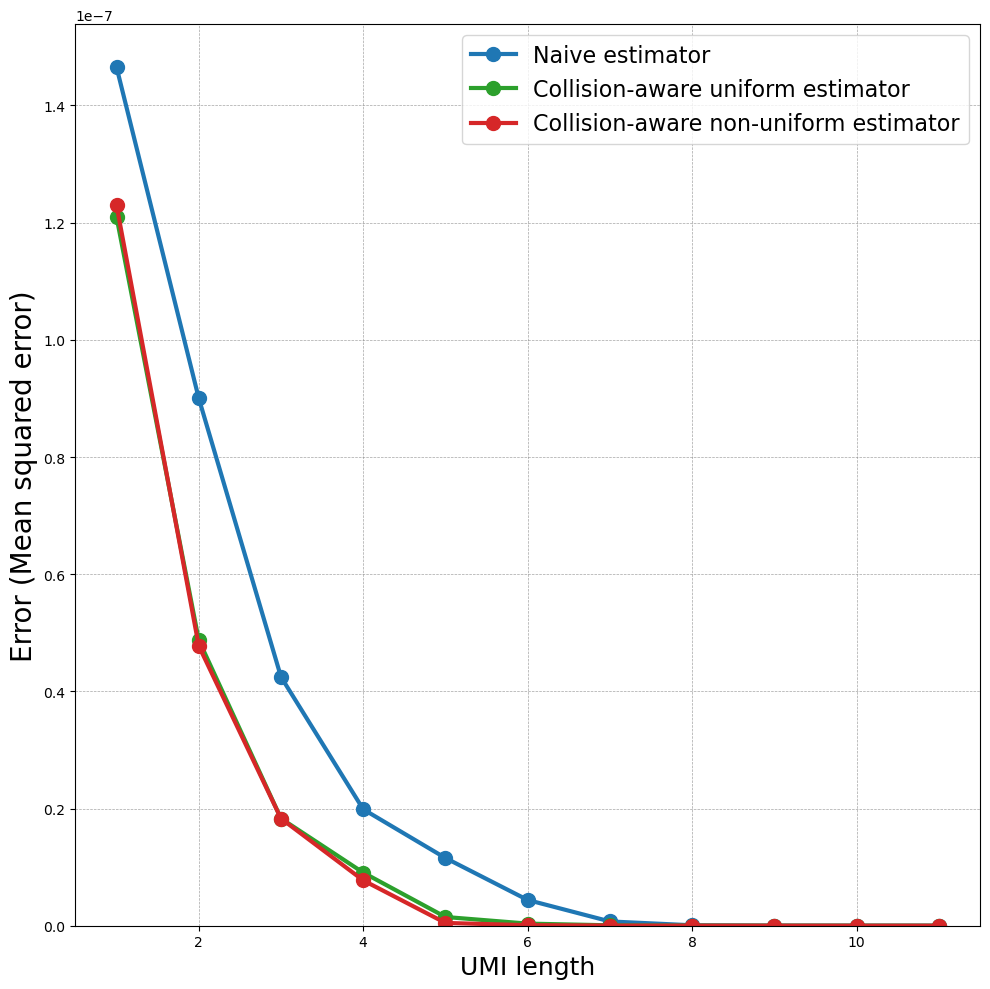

In [5]:
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt

def sse(p, q):
    """
    Calculate the Mean Squared Error (MSE) between two vectors p and q.
    Assumes that p and q are numpy arrays with the same length.
    """
    p = np.array(p, dtype=np.float64)
    q = np.array(q, dtype=np.float64)
    
    # Check for NaN or infinite values in p and q
    if np.isnan(p).any() or np.isinf(p).any():
        raise ValueError("Input array p contains NaN or infinite values.")
    if np.isnan(q).any() or np.isinf(q).any():
        raise ValueError("Input array q contains NaN or infinite values.")
    
    # Check if sums are zero to avoid division by zero in normalization
    sum_p = np.sum(p)
    sum_q = np.sum(q)
    if sum_p == 0 or sum_q == 0:
        raise ValueError("Sum of the input arrays should not be zero.")
    
    # Ensure both vectors are normalized
    p = p / sum_p
    q = q / sum_q
    
    # Compute the Mean Squared Error
    return np.sum((p - q) ** 2)

remove = np.array(['MALAT1'])

# Loading the regular adata matrices
common_path = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices"
regular_adata_dict = {}
for i in range(1, 13):
    path = f"{common_path}/adata_{i}.h5ad"
    adata = sc.read_h5ad(path)
    adata = adata[:, ~np.in1d(adata.var_names, remove)].copy()
    regular_adata_dict[i] = adata

# Loading the collision-aware uniform matrices
common_path2 = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/col_aware_unif_matrices"
unif_adata_dict = {}
for i in range(1, 13):
    path = f"{common_path2}/adata_{i}.h5ad"
    adata = sc.read_h5ad(path)
    adata = adata[:, ~np.in1d(adata.var_names, remove)].copy()
    unif_adata_dict[i] = adata
    
# Loading the collision-aware non-uniform matrices
common_path3 = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/col_aware_nunif_matrices"
non_unif_adata_dict = {}
for i in range(1, 12):
    path = f"{common_path3}/adata_{i}.h5ad"
    adata = sc.read_h5ad(path)
    adata = adata[:, ~np.in1d(adata.var_names, remove)].copy()
    non_unif_adata_dict[i] = adata
adata = sc.read_h5ad(f"{common_path}/adata_12.h5ad")
adata = adata[:, ~np.in1d(adata.var_names, remove)].copy()
non_unif_adata_dict[12] = adata

# This is the ground truth adata matrix
gt_adata12 = regular_adata_dict[12]

# Initialize lists to store the mean errors
mean_errors, mean_errors2, mean_errors3 = [], [], []

# Compute MSE (on row-normalized vectors) for regular and inverted matrices against the ground truth
for i in range(1, 13):
    # --- Regular vs GT ---
    common_cells = [c for c in gt_adata12.obs_names if c in regular_adata_dict[i].obs_names]
    common_genes = [g for g in gt_adata12.var_names if g in regular_adata_dict[i].var_names]
    reg_mat = regular_adata_dict[i][common_cells, common_genes].X
    gt_mat  = gt_adata12[common_cells, common_genes].X
    reg_mat = reg_mat.toarray() if hasattr(reg_mat, "toarray") else np.asarray(reg_mat)
    gt_mat  = gt_mat.toarray()  if hasattr(gt_mat,  "toarray") else np.asarray(gt_mat)
    reg_mat = reg_mat.astype(np.float64, copy=False)
    gt_mat  = gt_mat.astype(np.float64, copy=False)
    mask = (gt_mat >= 1.0)
    reg_mat = reg_mat * mask
    gt_mat  = gt_mat  * mask
    sum_reg = reg_mat.sum(axis=1, keepdims=True)
    sum_gt  = gt_mat.sum(axis=1, keepdims=True)
    reg_norm = reg_mat / sum_reg
    gt_norm  = gt_mat  / sum_gt
    per_row_mse = np.mean((reg_norm - gt_norm) ** 2, axis=1)
    mean_errors.append(float(np.mean(per_row_mse)))

    # --- Uniform inverted vs GT ---
    common_cells = [c for c in gt_adata12.obs_names if c in unif_adata_dict[i].obs_names]
    common_genes = [g for g in gt_adata12.var_names if g in unif_adata_dict[i].var_names]
    unif_mat = unif_adata_dict[i][common_cells, common_genes].X
    gt_mat   = gt_adata12[common_cells, common_genes].X
    unif_mat = unif_mat.toarray() if hasattr(unif_mat, "toarray") else np.asarray(unif_mat)
    gt_mat   = gt_mat.toarray()   if hasattr(gt_mat,  "toarray") else np.asarray(gt_mat)
    unif_mat = unif_mat.astype(np.float64, copy=False)
    gt_mat   = gt_mat.astype(np.float64, copy=False)
    mask = (gt_mat >= 1.0)
    unif_mat = unif_mat * mask
    gt_mat   = gt_mat   * mask
    sum_unif = unif_mat.sum(axis=1, keepdims=True)
    sum_gt   = gt_mat.sum(axis=1, keepdims=True)
    unif_norm = unif_mat / sum_unif
    gt_norm   = gt_mat  / sum_gt
    per_row_mse2 = np.mean((unif_norm - gt_norm) ** 2, axis=1)
    mean_errors2.append(float(np.mean(per_row_mse2)))

    # --- Non-uniform inverted vs GT ---
    common_cells = [c for c in gt_adata12.obs_names if c in non_unif_adata_dict[i].obs_names]
    common_genes = [g for g in gt_adata12.var_names if g in non_unif_adata_dict[i].var_names]
    nonunif_mat = non_unif_adata_dict[i][common_cells, common_genes].X
    gt_mat      = gt_adata12[common_cells, common_genes].X
    nonunif_mat = nonunif_mat.toarray() if hasattr(nonunif_mat, "toarray") else np.asarray(nonunif_mat)
    gt_mat      = gt_mat.toarray()      if hasattr(gt_mat,  "toarray") else np.asarray(gt_mat)
    nonunif_mat = nonunif_mat.astype(np.float64, copy=False)
    gt_mat      = gt_mat.astype(np.float64, copy=False)
    mask = (gt_mat >= 1.0)
    nonunif_mat = nonunif_mat * mask
    gt_mat      = gt_mat      * mask
    sum_non = nonunif_mat.sum(axis=1, keepdims=True)
    sum_gt  = gt_mat.sum(axis=1, keepdims=True)
    nonunif_norm = nonunif_mat / sum_non
    gt_norm      = gt_mat      / sum_gt
    per_row_mse3 = np.mean((nonunif_norm - gt_norm) ** 2, axis=1)
    mean_errors3.append(float(np.mean(per_row_mse3)))

print(mean_errors)
print(mean_errors2)
print(mean_errors3)

# Plotting the errors (mean only, no error bars)
num_experiments = len(mean_errors)

plt.figure(figsize=(10, 10))

plt.plot(range(1, num_experiments), mean_errors[:-1], 'o-', color='#1f77b4', linewidth=3, markersize=10, label='Naive estimator')
plt.plot(range(1, num_experiments), mean_errors2[:-1], 'o-', color='#2ca02c', linewidth=3, markersize=10, label='Collision-aware uniform estimator')
plt.plot(range(1, num_experiments), mean_errors3[:-1], 'o-', color='#d62728', linewidth=3, markersize=10, label='Collision-aware non-uniform estimator')

plt.xlabel('UMI length', fontsize=18)
plt.ylabel('Error (Mean squared error)', fontsize=20)
plt.ylim(bottom=0)
plt.legend(fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
plt.tight_layout()
plt.show()


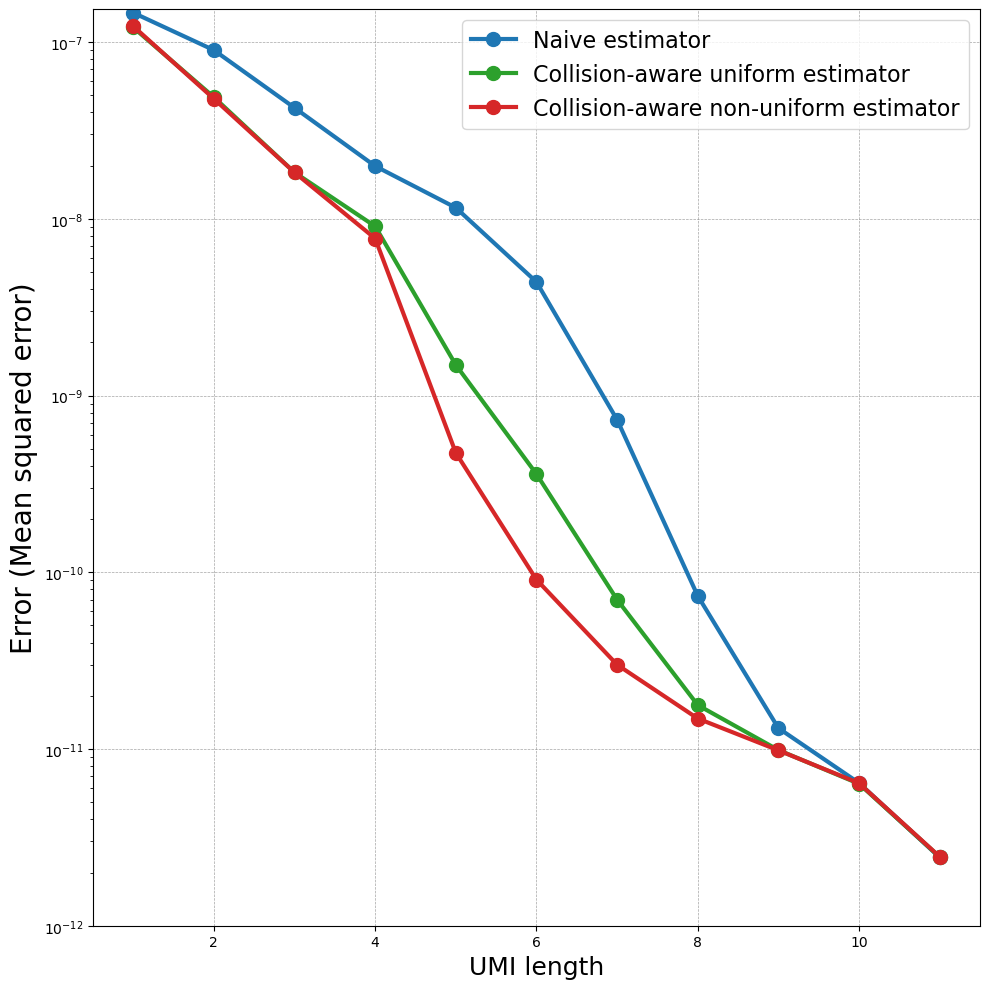

In [6]:
# Plotting the errors (mean only, no error bars)
num_experiments = len(mean_errors)

plt.figure(figsize=(10, 10))

plt.plot(range(1, num_experiments), mean_errors[:-1], 'o-', color='#1f77b4', linewidth=3, markersize=10, label='Naive estimator')
plt.plot(range(1, num_experiments), mean_errors2[:-1], 'o-', color='#2ca02c', linewidth=3, markersize=10, label='Collision-aware uniform estimator')
plt.plot(range(1, num_experiments), mean_errors3[:-1], 'o-', color='#d62728', linewidth=3, markersize=10, label='Collision-aware non-uniform estimator')

plt.xlabel('UMI length', fontsize=18)
plt.ylabel('Error (Mean squared error)', fontsize=20)
plt.ylim(bottom=1e-12)

plt.yscale('log')
plt.legend(fontsize=16)
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
plt.tight_layout()
plt.show()

## ONLY DOING MEDIANS

#### All genes, (SSE) - Plotting Median

[8.272963929753222e-08, 5.87403840475206e-08, 2.874932076812469e-08, 7.696251878786997e-09, 1.0479866854774716e-09, 1.2309612107758028e-10, 2.21197376519384e-11, 9.386154950999621e-12, 5.90383635655082e-12, 3.3842753721154313e-12, 1.0857759941118957e-12, 0.0]
[7.430479331962733e-08, 3.051909462482263e-08, 3.614665358475748e-09, 8.087790494469616e-10, 1.6464761540825858e-10, 4.091829510063727e-11, 1.6124797089498036e-11, 8.966894713720989e-12, 5.8143146603500715e-12, 3.382267224347924e-12, 1.0910674073936952e-12, 2.52651518475125e-18]
[7.512136349366846e-08, 2.9421530735754357e-08, 3.005783785400303e-09, 5.016760502889886e-10, 1.1654900866781012e-10, 3.49486046835082e-11, 1.5402352876101338e-11, 8.938910633911776e-12, 5.806810447998676e-12, 3.3860312943495076e-12, 1.0907515881153667e-12, 0.0]


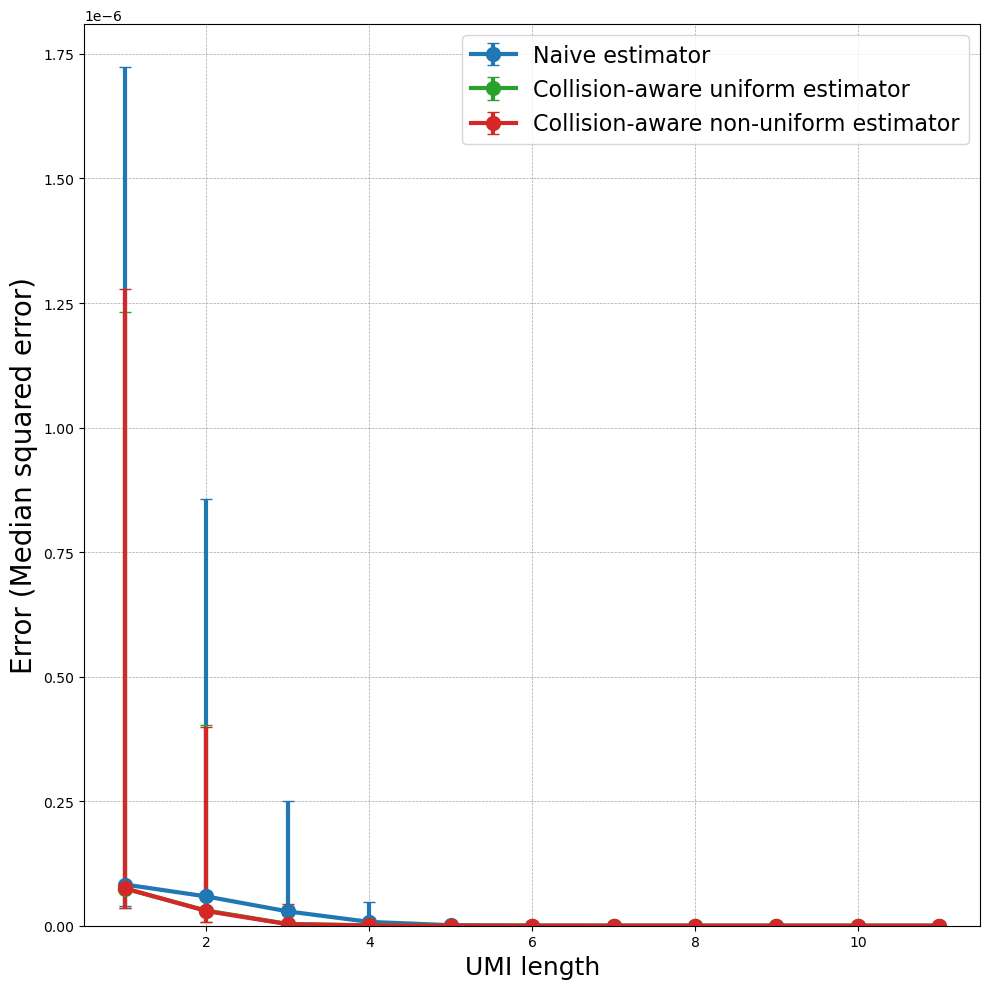

In [3]:
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt

dataset = "1k_PBMCs"  # Change to "10k_PBMCs" for the 10k dataset

def sse(p, q):
    """
    Calculate the Mean Squared Error (MSE) between two vectors p and q.
    Assumes that p and q are numpy arrays with the same length.
    """
    p = np.array(p, dtype=np.float64)
    q = np.array(q, dtype=np.float64)
    
    # Check for NaN or infinite values in p and q
    if np.isnan(p).any() or np.isinf(p).any():
        raise ValueError("Input array p contains NaN or infinite values.")
    if np.isnan(q).any() or np.isinf(q).any():
        raise ValueError("Input array q contains NaN or infinite values.")
    
    # Check if sums are zero to avoid division by zero in normalization
    sum_p = np.sum(p)
    sum_q = np.sum(q)
    if sum_p == 0 or sum_q == 0:
        raise ValueError("Sum of the input arrays should not be zero.")
    
    # Ensure both vectors are normalized
    p = p / sum_p
    q = q / sum_q
    
    # Compute the Mean Squared Error
    return np.sum((p - q) ** 2)

# Loading the regular adata matrices
common_path = f"/data/dagyeman/cellranger/bam_file_analysis/{dataset}/ub_objects/adata_matrices"
regular_adata_dict = {}
for i in range(1, 13):
    path = f"{common_path}/adata_{i}.h5ad"
    regular_adata_dict[i] = sc.read_h5ad(path)

# Loading the collision-aware uniform matrices
common_path2 = f"/data/dagyeman/cellranger/bam_file_analysis/{dataset}/ub_objects/col_aware_unif_matrices"
unif_adata_dict = {}
for i in range(1, 13):
    path = f"{common_path2}/adata_{i}.h5ad"
    unif_adata_dict[i] = sc.read_h5ad(path)
    
# Loading the collision-aware non-uniform matrices
common_path3 = f"/data/dagyeman/cellranger/bam_file_analysis/{dataset}/ub_objects/col_aware_nunif_matrices"
non_unif_adata_dict = {}
for i in range(1, 12):
    path = f"{common_path3}/adata_{i}.h5ad"
    non_unif_adata_dict[i] = sc.read_h5ad(path)
non_unif_adata_dict[12] = sc.read_h5ad(f"{common_path}/adata_12.h5ad")

# This is the ground truth adata matrix
gt_adata12 = regular_adata_dict[12]

# Initialize lists to store the median and (2.5%, 97.5%) CI distances
median_errors, ci_low_errors, ci_high_errors = [], [], []
median_errors2, ci_low_errors2, ci_high_errors2 = [], [], []
median_errors3, ci_low_errors3, ci_high_errors3 = [], [], []

# Compute MSE (on row-normalized vectors) for regular and inverted matrices against the ground truth
for i in range(1, 13):
    # --- Regular vs GT ---
    common_cells = [c for c in gt_adata12.obs_names if c in regular_adata_dict[i].obs_names]
    common_genes = [g for g in gt_adata12.var_names if g in regular_adata_dict[i].var_names]
    reg_mat = regular_adata_dict[i][common_cells, common_genes].X
    gt_mat  = gt_adata12[common_cells, common_genes].X
    reg_mat = reg_mat.toarray() if hasattr(reg_mat, "toarray") else np.asarray(reg_mat)
    gt_mat  = gt_mat.toarray()  if hasattr(gt_mat,  "toarray") else np.asarray(gt_mat)
    reg_mat = reg_mat.astype(np.float64, copy=False)
    gt_mat  = gt_mat.astype(np.float64, copy=False)
    # Mask: only genes with GT >= 1
    mask = (gt_mat >= 1.0)
    reg_mat = reg_mat * mask
    gt_mat  = gt_mat  * mask
    # Row-normalize to probabilities
    sum_reg = reg_mat.sum(axis=1, keepdims=True)
    sum_gt  = gt_mat.sum(axis=1, keepdims=True)
    reg_norm = reg_mat / sum_reg
    gt_norm  = gt_mat  / sum_gt
    # Per-row MSE, then aggregate (distribution across cells)
    per_row_mse = np.mean((reg_norm - gt_norm) ** 2, axis=1)
    med = float(np.median(per_row_mse))
    q_low, q_high = np.percentile(per_row_mse, [2.5, 97.5])
    median_errors.append(med)
    ci_low_errors.append(med - q_low)
    ci_high_errors.append(q_high - med)

    # --- Uniform inverted vs GT ---
    common_cells = [c for c in gt_adata12.obs_names if c in unif_adata_dict[i].obs_names]
    common_genes = [g for g in gt_adata12.var_names if g in unif_adata_dict[i].var_names]
    unif_mat = unif_adata_dict[i][common_cells, common_genes].X
    gt_mat   = gt_adata12[common_cells, common_genes].X
    unif_mat = unif_mat.toarray() if hasattr(unif_mat, "toarray") else np.asarray(unif_mat)
    gt_mat   = gt_mat.toarray()   if hasattr(gt_mat,  "toarray") else np.asarray(gt_mat)
    unif_mat = unif_mat.astype(np.float64, copy=False)
    gt_mat   = gt_mat.astype(np.float64, copy=False)
    mask = (gt_mat >= 1.0)
    unif_mat = unif_mat * mask
    gt_mat   = gt_mat   * mask
    sum_unif = unif_mat.sum(axis=1, keepdims=True)
    sum_gt   = gt_mat.sum(axis=1, keepdims=True)
    unif_norm = unif_mat / sum_unif
    gt_norm   = gt_mat  / sum_gt
    per_row_mse2 = np.mean((unif_norm - gt_norm) ** 2, axis=1)
    med2 = float(np.median(per_row_mse2))
    q_low2, q_high2 = np.percentile(per_row_mse2, [2.5, 97.5])
    median_errors2.append(med2)
    ci_low_errors2.append(med2 - q_low2)
    ci_high_errors2.append(q_high2 - med2)

    # --- Non-uniform inverted vs GT ---
    common_cells = [c for c in gt_adata12.obs_names if c in non_unif_adata_dict[i].obs_names]
    common_genes = [g for g in gt_adata12.var_names if g in non_unif_adata_dict[i].var_names]
    nonunif_mat = non_unif_adata_dict[i][common_cells, common_genes].X
    gt_mat      = gt_adata12[common_cells, common_genes].X
    nonunif_mat = nonunif_mat.toarray() if hasattr(nonunif_mat, "toarray") else np.asarray(nonunif_mat)
    gt_mat      = gt_mat.toarray()      if hasattr(gt_mat,  "toarray") else np.asarray(gt_mat)
    nonunif_mat = nonunif_mat.astype(np.float64, copy=False)
    gt_mat      = gt_mat.astype(np.float64, copy=False)
    mask = (gt_mat >= 1.0)
    nonunif_mat = nonunif_mat * mask
    gt_mat      = gt_mat      * mask
    sum_non = nonunif_mat.sum(axis=1, keepdims=True)
    sum_gt  = gt_mat.sum(axis=1, keepdims=True)
    nonunif_norm = nonunif_mat / sum_non
    gt_norm      = gt_mat      / sum_gt
    per_row_mse3 = np.mean((nonunif_norm - gt_norm) ** 2, axis=1)
    med3 = float(np.median(per_row_mse3))
    q_low3, q_high3 = np.percentile(per_row_mse3, [2.5, 97.5])
    median_errors3.append(med3)
    ci_low_errors3.append(med3 - q_low3)
    ci_high_errors3.append(q_high3 - med3)

print(median_errors)
print(median_errors2)
print(median_errors3)

# Plotting the errors (median with 2.5%/97.5% CI as asymmetric error bars)
num_experiments = len(median_errors)

plt.figure(figsize=(10, 10))

# Regular (Naive)
plt.errorbar(
    range(1, num_experiments),
    median_errors[:-1],
    yerr=[ci_low_errors[:-1], ci_high_errors[:-1]],
    fmt='o-',
    color='#1f77b4',
    ecolor='#1f77b4',
    linewidth=3,
    elinewidth=3,
    capsize=4,
    markersize=10,
    label='Naive estimator'
)

# Uniform inverted (Collision-aware)
plt.errorbar(
    range(1, num_experiments),
    median_errors2[:-1],
    yerr=[ci_low_errors2[:-1], ci_high_errors2[:-1]],
    fmt='o-',
    color='#2ca02c',
    ecolor='#2ca02c',
    linewidth=3,
    elinewidth=3,
    capsize=4,
    markersize=10,
    label='Collision-aware uniform estimator'
)

# Non-uniform inverted (Collision-aware)
plt.errorbar(
    range(1, num_experiments),
    median_errors3[:-1],
    yerr=[ci_low_errors3[:-1], ci_high_errors3[:-1]],
    fmt='o-',
    color='#d62728',
    ecolor='#d62728',
    linewidth=3,
    elinewidth=3,
    capsize=4,
    markersize=10,
    label='Collision-aware non-uniform estimator'
)

plt.xlabel('UMI length', fontsize=18)
plt.ylabel('Error (Median squared error)', fontsize=20)
plt.ylim(bottom=0)
plt.legend(fontsize=16)  
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
plt.tight_layout()
plt.show()



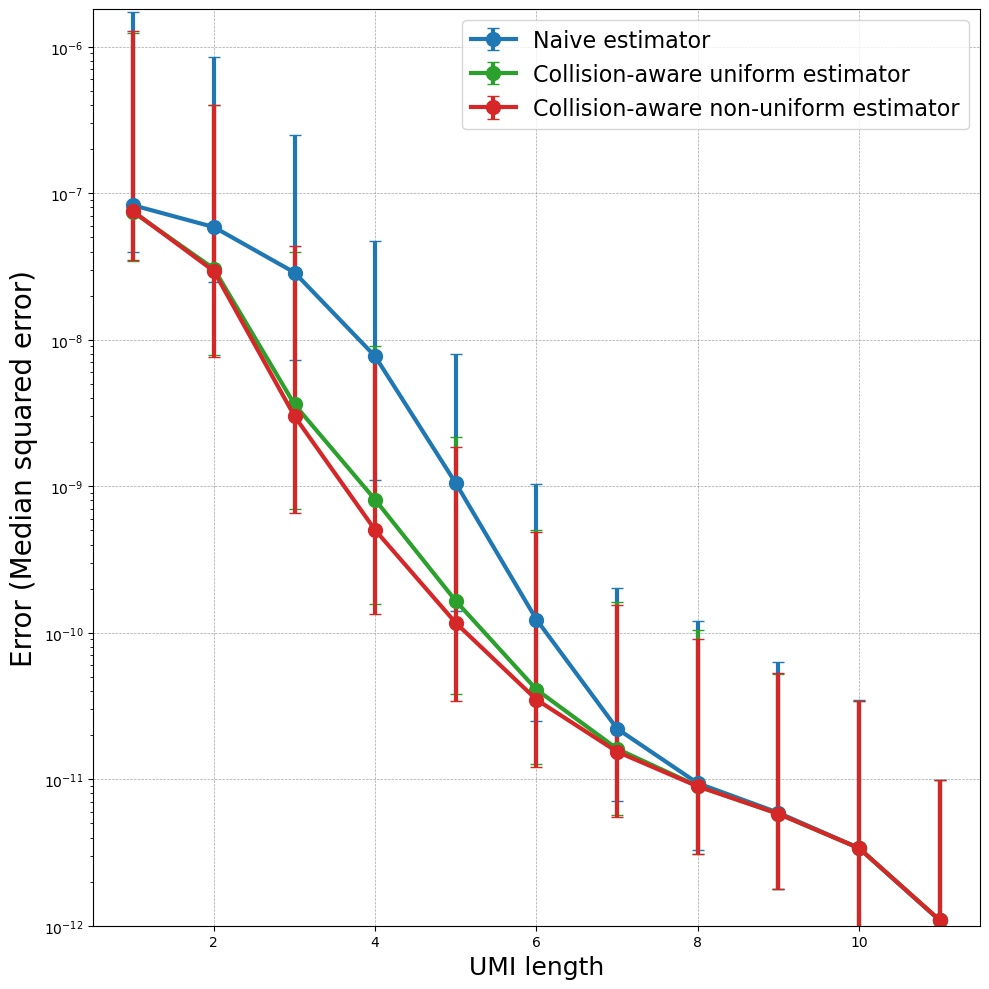

In [4]:
# Plotting the errors (median with 2.5%/97.5% CI as asymmetric error bars)
num_experiments = len(median_errors)

plt.figure(figsize=(10, 10))

# Regular (Naive)
plt.errorbar(
    range(1, num_experiments),
    median_errors[:-1],
    yerr=[ci_low_errors[:-1], ci_high_errors[:-1]],
    fmt='o-',
    color='#1f77b4',
    ecolor='#1f77b4',
    linewidth=3,
    elinewidth=3,
    capsize=4,
    markersize=10,
    label='Naive estimator'
)

# Uniform inverted (Collision-aware)
plt.errorbar(
    range(1, num_experiments),
    median_errors2[:-1],
    yerr=[ci_low_errors2[:-1], ci_high_errors2[:-1]],
    fmt='o-',
    color='#2ca02c',
    ecolor='#2ca02c',
    linewidth=3,
    elinewidth=3,
    capsize=4,
    markersize=10,
    label='Collision-aware uniform estimator'
)

# Non-uniform inverted (Collision-aware)
plt.errorbar(
    range(1, num_experiments),
    median_errors3[:-1],
    yerr=[ci_low_errors3[:-1], ci_high_errors3[:-1]],
    fmt='o-',
    color='#d62728',
    ecolor='#d62728',
    linewidth=3,
    elinewidth=3,
    capsize=4,
    markersize=10,
    label='Collision-aware non-uniform estimator'
)

plt.xlabel('UMI length', fontsize=18)
plt.ylabel('Error (Median squared error)', fontsize=20)
plt.ylim(bottom=1e-12)
plt.yscale('log')  # Set y-axis to log scale
plt.legend(fontsize=16)  
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
plt.tight_layout()
plt.show()


### All genes, NO MALAT1 

[5.604956516256762e-08, 3.41177577258143e-08, 1.1060657255964294e-08, 1.6499438643742093e-09, 1.8771385372774131e-10, 3.513888666422969e-11, 1.4456378966403582e-11, 8.850357059999024e-12, 6.024021500318063e-12, 3.527022346781407e-12, 1.1332287678600505e-12, 0.0]
[4.9104364189016737e-08, 1.0496347132807247e-08, 1.1885310151249788e-09, 2.069876667050134e-10, 6.070301490358972e-11, 2.4680210901603513e-11, 1.3335481286803043e-11, 8.711553929915187e-12, 6.00164526667452e-12, 3.5165791217685493e-12, 1.1374453329787149e-12, 7.445608902342976e-19]
[4.817857448652203e-08, 1.1141685677684506e-08, 1.12914150604154e-09, 2.19894257339769e-10, 6.294649912688821e-11, 2.507055087750983e-11, 1.3369207947201404e-11, 8.736375216805701e-12, 6.004274549393342e-12, 3.5108394353300424e-12, 1.1375572050721102e-12, 0.0]


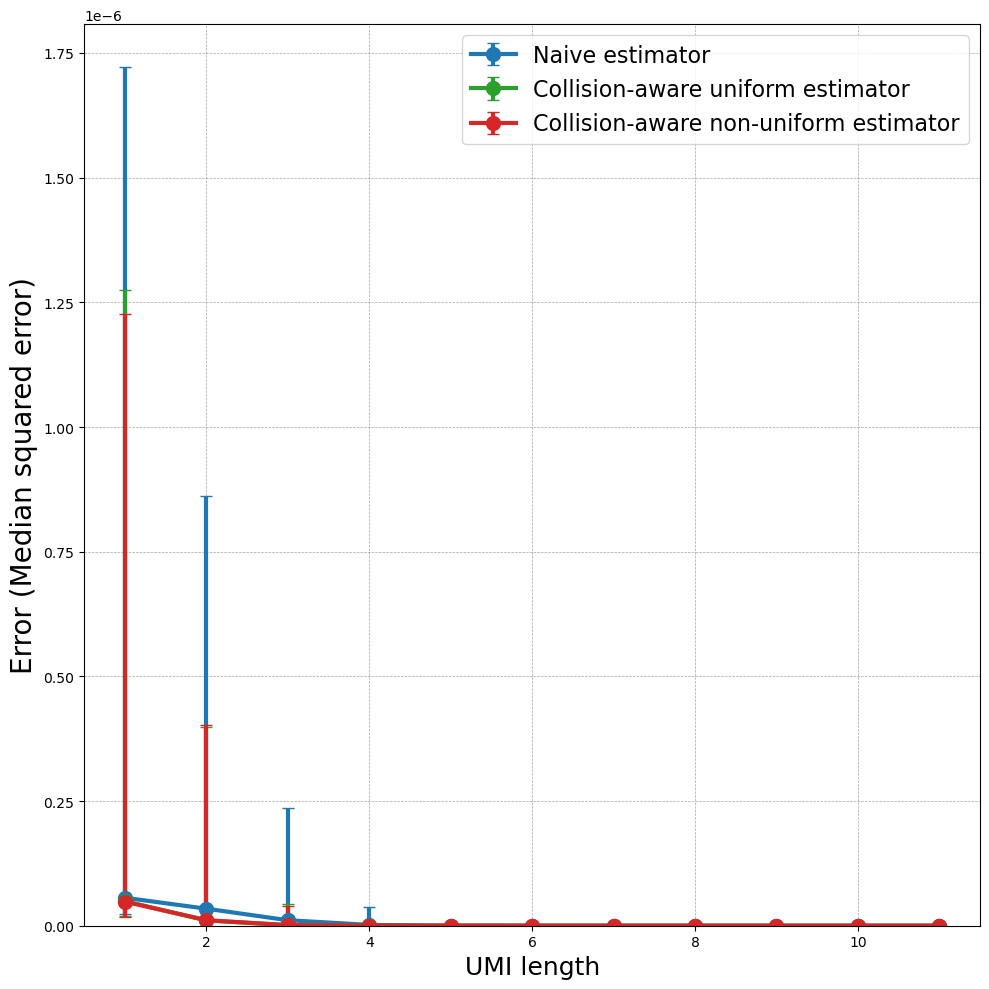

In [8]:
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt

def sse(p, q):
    """
    Calculate the Mean Squared Error (MSE) between two vectors p and q.
    Assumes that p and q are numpy arrays with the same length.
    """
    p = np.array(p, dtype=np.float64)
    q = np.array(q, dtype=np.float64)
    
    # Check for NaN or infinite values in p and q
    if np.isnan(p).any() or np.isinf(p).any():
        raise ValueError("Input array p contains NaN or infinite values.")
    if np.isnan(q).any() or np.isinf(q).any():
        raise ValueError("Input array q contains NaN or infinite values.")
    
    # Check if sums are zero to avoid division by zero in normalization
    sum_p = np.sum(p)
    sum_q = np.sum(q)
    if sum_p == 0 or sum_q == 0:
        raise ValueError("Sum of the input arrays should not be zero.")
    
    # Ensure both vectors are normalized
    p = p / sum_p
    q = q / sum_q
    
    # Compute the Mean Squared Error
    return np.sum((p - q) ** 2)

remove = np.array(['MALAT1'])  # remove MALAT1

# Loading the regular adata matrices
common_path = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices"
regular_adata_dict = {}
for i in range(1, 13):
    path = f"{common_path}/adata_{i}.h5ad"
    adata = sc.read_h5ad(path)
    adata = adata[:, ~np.in1d(adata.var_names, remove)].copy()
    regular_adata_dict[i] = adata

# Loading the collision-aware uniform matrices
common_path2 = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/col_aware_unif_matrices"
unif_adata_dict = {}
for i in range(1, 13):
    path = f"{common_path2}/adata_{i}.h5ad"
    adata = sc.read_h5ad(path)
    adata = adata[:, ~np.in1d(adata.var_names, remove)].copy()
    unif_adata_dict[i] = adata
    
# Loading the collision-aware non-uniform matrices
common_path3 = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/col_aware_nunif_matrices"
non_unif_adata_dict = {}
for i in range(1, 12):
    path = f"{common_path3}/adata_{i}.h5ad"
    adata = sc.read_h5ad(path)
    adata = adata[:, ~np.in1d(adata.var_names, remove)].copy()
    non_unif_adata_dict[i] = adata
adata = sc.read_h5ad(f"{common_path}/adata_12.h5ad")
adata = adata[:, ~np.in1d(adata.var_names, remove)].copy()
non_unif_adata_dict[12] = adata

# This is the ground truth adata matrix
gt_adata12 = regular_adata_dict[12]

# Initialize lists to store the median and (2.5%, 97.5%) CI distances
median_errors, ci_low_errors, ci_high_errors = [], [], []
median_errors2, ci_low_errors2, ci_high_errors2 = [], [], []
median_errors3, ci_low_errors3, ci_high_errors3 = [], [], []

# Compute MSE (on row-normalized vectors) for regular and inverted matrices against the ground truth
for i in range(1, 13):
    # --- Regular vs GT ---
    common_cells = [c for c in gt_adata12.obs_names if c in regular_adata_dict[i].obs_names]
    common_genes = [g for g in gt_adata12.var_names if g in regular_adata_dict[i].var_names]
    reg_mat = regular_adata_dict[i][common_cells, common_genes].X
    gt_mat  = gt_adata12[common_cells, common_genes].X
    reg_mat = reg_mat.toarray() if hasattr(reg_mat, "toarray") else np.asarray(reg_mat)
    gt_mat  = gt_mat.toarray()  if hasattr(gt_mat,  "toarray") else np.asarray(gt_mat)
    reg_mat = reg_mat.astype(np.float64, copy=False)
    gt_mat  = gt_mat.astype(np.float64, copy=False)
    # Mask: only genes with GT >= 1
    mask = (gt_mat >= 1.0)
    reg_mat = reg_mat * mask
    gt_mat  = gt_mat  * mask
    # Row-normalize to probabilities
    sum_reg = reg_mat.sum(axis=1, keepdims=True)
    sum_gt  = gt_mat.sum(axis=1, keepdims=True)
    reg_norm = reg_mat / sum_reg
    gt_norm  = gt_mat  / sum_gt
    # Per-row MSE, then aggregate (distribution across cells)
    per_row_mse = np.mean((reg_norm - gt_norm) ** 2, axis=1)
    med = float(np.median(per_row_mse))
    q_low, q_high = np.percentile(per_row_mse, [2.5, 97.5])
    median_errors.append(med)
    ci_low_errors.append(med - q_low)
    ci_high_errors.append(q_high - med)

    # --- Uniform inverted vs GT ---
    common_cells = [c for c in gt_adata12.obs_names if c in unif_adata_dict[i].obs_names]
    common_genes = [g for g in gt_adata12.var_names if g in unif_adata_dict[i].var_names]
    unif_mat = unif_adata_dict[i][common_cells, common_genes].X
    gt_mat   = gt_adata12[common_cells, common_genes].X
    unif_mat = unif_mat.toarray() if hasattr(unif_mat, "toarray") else np.asarray(unif_mat)
    gt_mat   = gt_mat.toarray()   if hasattr(gt_mat,  "toarray") else np.asarray(gt_mat)
    unif_mat = unif_mat.astype(np.float64, copy=False)
    gt_mat   = gt_mat.astype(np.float64, copy=False)
    mask = (gt_mat >= 1.0)
    unif_mat = unif_mat * mask
    gt_mat   = gt_mat   * mask
    sum_unif = unif_mat.sum(axis=1, keepdims=True)
    sum_gt   = gt_mat.sum(axis=1, keepdims=True)
    unif_norm = unif_mat / sum_unif
    gt_norm   = gt_mat  / sum_gt
    per_row_mse2 = np.mean((unif_norm - gt_norm) ** 2, axis=1)
    med2 = float(np.median(per_row_mse2))
    q_low2, q_high2 = np.percentile(per_row_mse2, [2.5, 97.5])
    median_errors2.append(med2)
    ci_low_errors2.append(med2 - q_low2)
    ci_high_errors2.append(q_high2 - med2)

    # --- Non-uniform inverted vs GT ---
    common_cells = [c for c in gt_adata12.obs_names if c in non_unif_adata_dict[i].obs_names]
    common_genes = [g for g in gt_adata12.var_names if g in non_unif_adata_dict[i].var_names]
    nonunif_mat = non_unif_adata_dict[i][common_cells, common_genes].X
    gt_mat      = gt_adata12[common_cells, common_genes].X
    nonunif_mat = nonunif_mat.toarray() if hasattr(nonunif_mat, "toarray") else np.asarray(nonunif_mat)
    gt_mat      = gt_mat.toarray()      if hasattr(gt_mat,  "toarray") else np.asarray(gt_mat)
    nonunif_mat = nonunif_mat.astype(np.float64, copy=False)
    gt_mat      = gt_mat.astype(np.float64, copy=False)
    mask = (gt_mat >= 1.0)
    nonunif_mat = nonunif_mat * mask
    gt_mat      = gt_mat      * mask
    sum_non = nonunif_mat.sum(axis=1, keepdims=True)
    sum_gt  = gt_mat.sum(axis=1, keepdims=True)
    nonunif_norm = nonunif_mat / sum_non
    gt_norm      = gt_mat      / sum_gt
    per_row_mse3 = np.mean((nonunif_norm - gt_norm) ** 2, axis=1)
    med3 = float(np.median(per_row_mse3))
    q_low3, q_high3 = np.percentile(per_row_mse3, [2.5, 97.5])
    median_errors3.append(med3)
    ci_low_errors3.append(med3 - q_low3)
    ci_high_errors3.append(q_high3 - med3)

print(median_errors)
print(median_errors2)
print(median_errors3)

# Plotting the errors (median with 2.5%/97.5% CI as asymmetric error bars)
num_experiments = len(median_errors)

plt.figure(figsize=(10, 10))

# Regular (Naive)
plt.errorbar(
    range(1, num_experiments),
    median_errors[:-1],
    yerr=[ci_low_errors[:-1], ci_high_errors[:-1]],
    fmt='o-',
    color='#1f77b4',
    ecolor='#1f77b4',
    linewidth=3,
    elinewidth=3,
    capsize=4,
    markersize=10,
    label='Naive estimator'
)

# Uniform inverted (Collision-aware)
plt.errorbar(
    range(1, num_experiments),
    median_errors2[:-1],
    yerr=[ci_low_errors2[:-1], ci_high_errors2[:-1]],
    fmt='o-',
    color='#2ca02c',
    ecolor='#2ca02c',
    linewidth=3,
    elinewidth=3,
    capsize=4,
    markersize=10,
    label='Collision-aware uniform estimator'
)

# Non-uniform inverted (Collision-aware)
plt.errorbar(
    range(1, num_experiments),
    median_errors3[:-1],
    yerr=[ci_low_errors3[:-1], ci_high_errors3[:-1]],
    fmt='o-',
    color='#d62728',
    ecolor='#d62728',
    linewidth=3,
    elinewidth=3,
    capsize=4,
    markersize=10,
    label='Collision-aware non-uniform estimator'
)

plt.xlabel('UMI length', fontsize=18)
plt.ylabel('Error (Median squared error)', fontsize=20)
plt.ylim(bottom=0)
plt.legend(fontsize=16)  
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
plt.tight_layout()
plt.show()


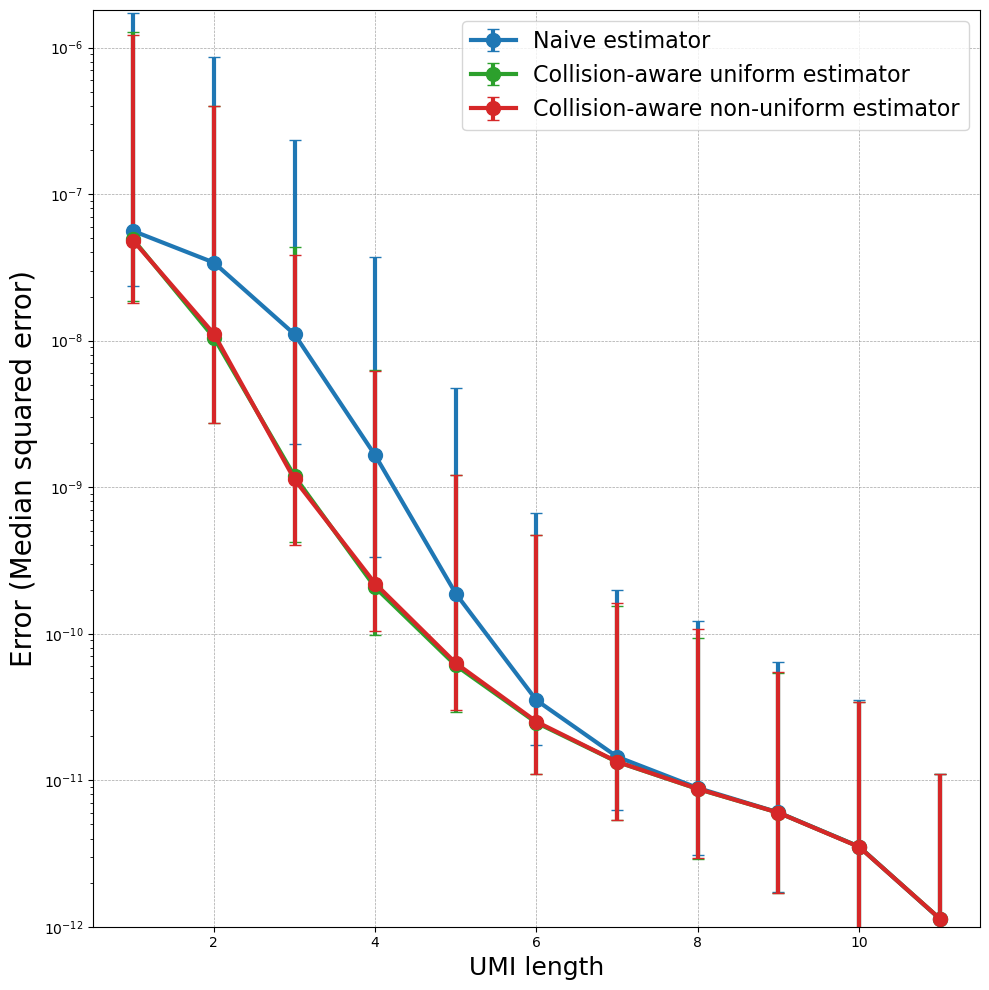

In [9]:
# Plotting the errors (median with 2.5%/97.5% CI as asymmetric error bars)
num_experiments = len(median_errors)

plt.figure(figsize=(10, 10))

# Regular (Naive)
plt.errorbar(
    range(1, num_experiments),
    median_errors[:-1],
    yerr=[ci_low_errors[:-1], ci_high_errors[:-1]],
    fmt='o-',
    color='#1f77b4',
    ecolor='#1f77b4',
    linewidth=3,
    elinewidth=3,
    capsize=4,
    markersize=10,
    label='Naive estimator'
)

# Uniform inverted (Collision-aware)
plt.errorbar(
    range(1, num_experiments),
    median_errors2[:-1],
    yerr=[ci_low_errors2[:-1], ci_high_errors2[:-1]],
    fmt='o-',
    color='#2ca02c',
    ecolor='#2ca02c',
    linewidth=3,
    elinewidth=3,
    capsize=4,
    markersize=10,
    label='Collision-aware uniform estimator'
)

# Non-uniform inverted (Collision-aware)
plt.errorbar(
    range(1, num_experiments),
    median_errors3[:-1],
    yerr=[ci_low_errors3[:-1], ci_high_errors3[:-1]],
    fmt='o-',
    color='#d62728',
    ecolor='#d62728',
    linewidth=3,
    elinewidth=3,
    capsize=4,
    markersize=10,
    label='Collision-aware non-uniform estimator'
)

plt.xlabel('UMI length', fontsize=18)
plt.ylabel('Error (Median squared error)', fontsize=20)
plt.ylim(bottom=0)
plt.yscale('log')  # Set y-axis to log scale
plt.ylim(bottom=1e-12)
plt.legend(fontsize=16)  
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
plt.tight_layout()
plt.show()


## 3. Differential expression analysis

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

#### Step 1: Load the adata matrices, load labels from celltypist

In [14]:
# Load data31
dataset = "1k_PBMCs"  # Change to "10k_PBMCs" for the 10k dataset
j = 5
adata_12 = sc.read_h5ad(f"/data/dagyeman/cellranger/bam_file_analysis/{dataset}/ub_objects/adata_matrices/adata_12.h5ad")  # Ground truth
adata_naive  = sc.read_h5ad(f"/data/dagyeman/cellranger/bam_file_analysis/{dataset}/ub_objects/adata_matrices/adata_{j}.h5ad")   # Naive UMI-5
adata_pred = sc.read_h5ad(f"/data/dagyeman/cellranger/bam_file_analysis/{dataset}/ub_objects/col_aware_nunif_matrices/adata_{j}.h5ad")  # Predicted UMI-5


assert adata_12.obs_names.equals(adata_naive.obs_names), "Cell barcodes differ!"
assert adata_12.var_names.equals(adata_naive.var_names), "Genes differ!"


# Load cell annotation labels (e.g., cell types)
labels = sc.read_h5ad(f"/data/dagyeman/cellranger/bam_file_analysis/{dataset}/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_12.h5ad")
reference_labels = labels.obs['majority_voting'].copy()
# Count the number of cells in each group
cell_counts = reference_labels.value_counts()

# Filter groups with 100 or more cells
filtered_cell_counts = cell_counts[cell_counts >= 100]

# Display the result
print(filtered_cell_counts)

gene = 'B_naive' ### change gene name
# Convert annotations: CD14_mono → CD14_mono, all others → Other cells
binary_labels = reference_labels.apply(lambda x: gene if x == gene else 'Other cells')
print(binary_labels)


majority_voting
CD14_mono    381
CD4.Naive    246
B_naive      142
Name: count, dtype: int64
barcode
AAACCCAAGGAGAGTA-1    Other cells
AAACGCTTCAGCCCAG-1    Other cells
AAAGAACAGACGACTG-1    Other cells
AAAGAACCAATGGCAG-1    Other cells
AAAGAACGTCTGCAAT-1    Other cells
                         ...     
TTTCCTCTCTCTTGCG-1    Other cells
TTTGATCTCTTTGGAG-1    Other cells
TTTGGTTAGTAACCTC-1    Other cells
TTTGGTTGTAGAATAC-1    Other cells
TTTGTTGCAATTAGGA-1        B_naive
Name: majority_voting, Length: 1232, dtype: object


#### Step 2: Pre-processing datasets

In [15]:

adata_12.raw  = adata_12.copy()
adata_naive.raw = adata_naive.copy()
adata_pred.raw  = adata_pred.copy()

# sc.pp.highly_variable_genes(adata_12, n_top_genes=2000, flavor="seurat_v3")
sc.pp.normalize_total(adata_12, target_sum=1e4)
sc.pp.log1p(adata_12)  # Log-transform the data
adata_12.obs['label'] = binary_labels
print("This is the matrix for adata_12", adata_12.X)

# Repeat for naive and pred
# sc.pp.highly_variable_genes(adata_naive, n_top_genes=2000, flavor="seurat_v3")
sc.pp.normalize_total(adata_naive, target_sum=1e4)
sc.pp.log1p(adata_naive)  # Log-transform the data
adata_naive.obs['label'] = adata_12.obs['label'].loc[adata_naive.obs_names]
print("This is the matrix for adata_naive", adata_naive.X)

# sc.pp.highly_variable_genes(adata_pred, n_top_genes=2000, flavor="seurat_v3")
sc.pp.normalize_total(adata_pred, target_sum=1e4) 
sc.pp.log1p(adata_pred)  # Log-transform the data
adata_pred.obs['label'] = adata_12.obs['label'].loc[adata_pred.obs_names]
print("This is the matrix for adata_pred", adata_pred.X)

    
    
# print("This is the matrix for adata_12", adata_12.X)
# print("This is the matrix for adata_naive", adata_naive.X)
# print("This is the matrix for adata_pred", adata_pred.X)


This is the matrix for adata_12 [[0.         0.         0.         ... 0.91707144 1.17955576 0.5601735 ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         1.68582339 ... 0.90244774 0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         1.82676689]
 [0.         0.         0.         ... 0.50130374 1.82567404 0.        ]
 [0.         0.         0.         ... 1.30317499 0.         0.        ]]
This is the matrix for adata_naive [[0.         0.         0.         ... 0.92923343 1.1935741  0.56887764]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         1.69932847 ... 0.91231921 0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         1.6084786 ]
 [0.         0.         0.         ... 0.5076723  1.83917651 0.        ]
 [0.         0.         0.         ... 1.31441432 0.         0.        ]]
This is the matrix for adata_pred [[0.       

### Step 3: Run DE using t-test

- The following command compares gene expression between one cluster and all other clusters, across all genes, to find the most distinctly expressed genes

- For each gene and each cluster, scanpy computes log fold change, p-value, adj p-value, scores for ranking genes \n

- Tell you which genes are significanty more (or less) expressed in one cluster compared to the others

In [16]:
method = 'wilcoxon'  # Using t-test for differential expression analysis
sc.tl.rank_genes_groups(
    adata_12,
    groupby='label',
    method=method,
    key_added=method,
    use_raw=False
)
sc.tl.rank_genes_groups(
    adata_naive,
    groupby='label',
    method=method,
    key_added=method,
    use_raw=False
)
sc.tl.rank_genes_groups(
    adata_pred,
    groupby='label',
    method=method,
    key_added=method,
    use_raw=False
)

### Step 5: Extract DE results for one cluster

- extracting differential gene expression results for  specific cluster after running rank_gene_groups 
- The function below returns a pandas dataframe containing the ranked list of differentially expressed genes from a specific group clsuter
- group 1: You're pulling the DE genes where cluster "1" is compared against all the other clusters (one vs. rest)
- key = "t-test": You'res saying, "Give me the results from the DE analysis that used the t-test method
- de_12 = DE genes for cluster 1 using ground truth UMI-12 counts 
- de_5 = DE genes for cluster 1 using naive UMI-5 counts 
- de_5_pred: DE genes for cluster 1 usig predicited UMI-5 counts 

In [17]:
# gene = 'CD4.Naive'  # The gene of interest for differential expression analysis
de_12 = sc.get.rank_genes_groups_df(adata_12, group=gene, key=method)
de_naive = sc.get.rank_genes_groups_df(adata_naive, group=gene, key=method)
de_pred = sc.get.rank_genes_groups_df(adata_pred, group=gene, key=method)
print(de_12.head(10))
print("==================================")
print(de_naive.head(10))
print("==================================")
print(de_pred.head(10))
assert(len(de_12)) == len(de_naive) == len(de_pred), "Number of DE genes differ across datasets!"

       names     scores  logfoldchanges         pvals     pvals_adj
0  LINC00926  18.831665        6.577267  4.154934e-79  1.172772e-74
1      BANK1  18.586550        6.389452  4.128943e-77  5.827177e-73
2       AFF3  18.439106        5.575611  6.378751e-76  6.001554e-72
3       CD37  18.380428        2.632469  1.884731e-75  1.329960e-71
4    RALGPS2  18.287899        5.142606  1.033199e-74  5.832613e-71
5      MS4A1  18.262323        5.668053  1.651156e-74  7.767589e-71
6       IGHM  18.243515        7.479176  2.329788e-74  9.394372e-71
7      CD79A  18.183084        6.100919  7.026905e-74  2.479268e-70
8       PAX5  18.141708        5.977286  1.493154e-73  4.682863e-70
9      FCRL1  18.036392        6.123219  1.009230e-72  2.848654e-69
       names     scores  logfoldchanges         pvals     pvals_adj
0  LINC00926  18.825146        6.577286  4.699216e-79  1.326401e-74
1      BANK1  18.587805        6.381166  4.033563e-77  5.692567e-73
2       AFF3  18.448885        5.557538  5.32318

In [18]:
import pandas as pd
import numpy as np
import scipy.sparse as sp

dataset = "1k_PBMCs"  # Change to "10k_PBMCs" for the 10k dataset
adata_gt = sc.read_h5ad(f"/data/dagyeman/cellranger/bam_file_analysis/{dataset}/ub_objects/adata_matrices/adata_12.h5ad")  # Ground truth
# 1) Compute average counts per gene from adata_12
X12 = adata_gt.X
if sp.issparse(X12):
    avg12 = np.asarray(X12.mean(axis=0)).ravel()
else:
    avg12 = X12.mean(axis=0)

df_avg12 = pd.DataFrame({
    "gene": adata_gt.var_names,
    "avg_count": avg12
})

# 2) Merge into new DE DataFrames (preserving original de_* unmodified)
de_12_avg    = de_12   .merge(df_avg12, left_on="names", right_on="gene", how="left") \
                       .drop(columns="gene")
de_naive_avg = de_naive.merge(df_avg12, left_on="names", right_on="gene", how="left") \
                       .drop(columns="gene")
de_pred_avg  = de_pred .merge(df_avg12, left_on="names", right_on="gene", how="left") \
                       .drop(columns="gene")

# 3) Inspect
print("Ground truth DE + avg:\n",    de_12_avg   .head(), "\n")
print("Naive DE + avg:\n",           de_naive_avg.head(), "\n")
print("Predicted DE + avg:\n",       de_pred_avg .head(), "\n")
print(len(de_12_avg), len(de_naive_avg), len(de_pred_avg))


Ground truth DE + avg:
        names     scores  logfoldchanges         pvals     pvals_adj  avg_count
0  LINC00926  18.831665        6.577267  4.154934e-79  1.172772e-74   1.176948
1      BANK1  18.586550        6.389452  4.128943e-77  5.827177e-73   3.078734
2       AFF3  18.439106        5.575611  6.378751e-76  6.001554e-72   6.895292
3       CD37  18.380428        2.632469  1.884731e-75  1.329960e-71   5.177760
4    RALGPS2  18.287899        5.142606  1.033199e-74  5.832613e-71   2.346591 

Naive DE + avg:
        names     scores  logfoldchanges         pvals     pvals_adj  avg_count
0  LINC00926  18.825146        6.577286  4.699216e-79  1.326401e-74   1.176948
1      BANK1  18.587805        6.381166  4.033563e-77  5.692567e-73   3.078734
2       AFF3  18.448885        5.557538  5.323187e-76  5.008409e-72   6.895292
3       CD37  18.380680        2.617629  1.876038e-75  1.323826e-71   5.177760
4    RALGPS2  18.283134        5.132824  1.127539e-74  6.365184e-71   2.346591 

Predict

#### Step 6: Differential expression alignment: log-FC shifts vs. UMI-12 (naïve vs predicted)

Total |log₂(lfc_12/lfc_naive) U[5]| = 0.024
Total |log₂(lfc_12/lfc_pred) U[5]| = 0.002


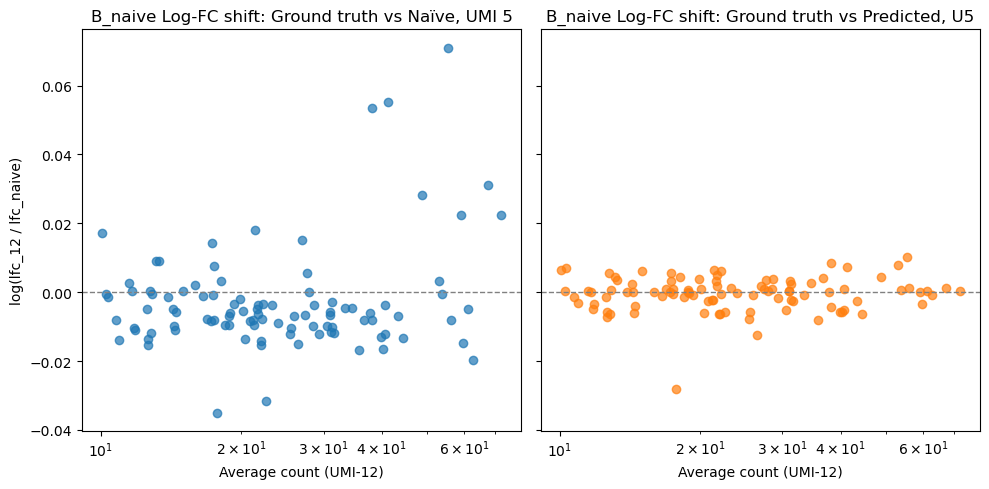

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Filter genes from UMI-12 results

fc_hi = np.log2(1.25)
fc_lo = -np.log2(1.25)
pcol = 'pvals_adj' if 'pvals_adj' in de_12_avg.columns else 'pvals'

keep_genes = de_12_avg.loc[
    ((de_12_avg['logfoldchanges'] >= fc_hi) | (de_12_avg['logfoldchanges'] <= fc_lo)) &
    (de_12_avg[pcol] < 0.05) &
    (de_12_avg['avg_count'] >= 10),
    'names'
]

# Keep only these genes in all datasets
de_12_avg    = de_12_avg[de_12_avg['names'].isin(keep_genes)]
de_naive_avg = de_naive_avg[de_naive_avg['names'].isin(keep_genes)]
de_pred_avg  = de_pred_avg[de_pred_avg['names'].isin(keep_genes)]

# 3) Quick diagnostics: did we lose any genes in the other tables?
lost_naive = set(de_12_avg['names']) - set(de_naive_avg['names'])
lost_pred  = set(de_12_avg['names']) - set(de_pred_avg['names'])
if lost_naive:
    print(f"[warn] {len(lost_naive)} genes in UMI-12 are missing from naive.")
if lost_pred:
    print(f"[warn] {len(lost_pred)} genes in UMI-12 are missing from pred.")


### Left merge of the ground truth dataset
df = (
    de_12_avg[['names', 'logfoldchanges', 'avg_count']].rename(columns={'logfoldchanges': 'lfc_12'})
      .merge(
          de_naive_avg[['names', 'logfoldchanges']].rename(columns={'logfoldchanges': 'lfc_naive'}),
          on='names', how='left', validate='one_to_one'
      )
      .merge(
          de_pred_avg[['names', 'logfoldchanges']].rename(columns={'logfoldchanges': 'lfc_pred'}),
          on='names', how='left', validate='one_to_one'
      )
)


# Sort by abundance
df = df.sort_values('avg_count').reset_index(drop=True)

# Calculate log-FC differences from UMI-12
df["logrf_naive"] = df['lfc_naive'] - df['lfc_12']
df["logrf_pred"]  = df['lfc_pred']  - df['lfc_12']

# Sum of squared differences
sum_squared_naive = (df['logrf_naive'] ** 2).sum()
sum_squared_pred  = (df['logrf_pred']  ** 2).sum()

print(f"Total |log₂(lfc_12/lfc_naive) U[{j}]| = {sum_squared_naive:.3f}")
print(f"Total |log₂(lfc_12/lfc_pred) U[{j}]| = {sum_squared_pred:.3f}")

# Plot results
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# Naive vs ground truth
axes[0].scatter(df['avg_count'], df['logrf_naive'], alpha=0.7)
axes[0].axhline(0, color='grey', linestyle='--', linewidth=1)
axes[0].set_xlabel('Average count (UMI-12)')
axes[0].set_ylabel('log(lfc_12 / lfc_naive)')
axes[0].set_xscale('log')
axes[0].set_title(f'{gene} Log-FC shift: Ground truth vs Naïve, UMI {j}')

# Predicted vs ground truth
axes[1].scatter(df['avg_count'], df['logrf_pred'], alpha=0.7, color='C1')
axes[1].axhline(0, color='grey', linestyle='--', linewidth=1)
axes[1].set_xlabel('Average count (UMI-12)')
axes[1].set_xscale('log')
axes[1].set_title(f'{gene} Log-FC shift: Ground truth vs Predicted, U{j}')

plt.tight_layout()
plt.show()


In [11]:
len(df)

111

#### Step 8: Big loop for entire pipeline for all k in order to generate cumulative plot

In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse as sp
import matplotlib.pyplot as plt
from pathlib import Path

# -------------------------
# Config
# -------------------------
UMI_MIN, UMI_MAX = 1, 13     # will skip any missing j via try/except
GENE_LABEL = 'CD14_mono'
METHOD = 'wilcoxon'
FC_HI = np.log2(1.25)        # ≈ 0.32
FC_LO = -np.log2(1.25)       # ≈ -0.32
PVAL_THRESH = 0.05
AVG_COUNT_MIN = 10

GT_PATH = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/adata_12.h5ad"
LAB_PATH = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_12.h5ad"
NAIVE_FMT = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/adata_{j}.h5ad"
PRED_FMT  = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/adata_{j}.h5ad"

OUT_PDF  = "/data/dagyeman/cellranger/bam_file_analysis/paper_figures/mse_with_empirical_95ci.pdf"
OUT_CSV  = "/data/dagyeman/cellranger/bam_file_analysis/paper_figures/mse_with_empirical_95ci.csv"

# -------------------------
# Ground truth + labels (once)
# -------------------------
adata_gt = sc.read_h5ad(GT_PATH)
labels = sc.read_h5ad(LAB_PATH)
reference_labels = labels.obs['majority_voting'].copy()
binary_labels = reference_labels.apply(lambda x: GENE_LABEL if x == GENE_LABEL else 'Other cells')

# normalized GT copy for DE
adata_12_norm = adata_gt.copy()
sc.pp.normalize_total(adata_12_norm, target_sum=1e4)
sc.pp.log1p(adata_12_norm)
adata_12_norm.obs['label'] = binary_labels.loc[adata_12_norm.obs_names]

# GT DE
sc.tl.rank_genes_groups(
    adata_12_norm,
    groupby='label',
    method=METHOD,
    key_added=METHOD,
    use_raw=False
)
de_12 = sc.get.rank_genes_groups_df(adata_12_norm, group=GENE_LABEL, key=METHOD)

# avg counts from *raw* GT
X12 = adata_gt.X
avg12 = (np.asarray(X12.mean(axis=0)).ravel() if sp.issparse(X12) else X12.mean(axis=0))
df_avg12 = pd.DataFrame({"gene": adata_gt.var_names, "avg_count": avg12})

# attach avg to GT DE
de_12_avg = de_12.merge(df_avg12, left_on="names", right_on="gene", how="left").drop(columns="gene")

# filter genes based on GT only
pcol = 'pvals_adj' if 'pvals_adj' in de_12_avg.columns else 'pvals'
keep_genes = de_12_avg.loc[
    ((de_12_avg['logfoldchanges'] >= FC_HI) | (de_12_avg['logfoldchanges'] <= FC_LO))
    & (de_12_avg[pcol] < PVAL_THRESH)
    & (de_12_avg['avg_count'] >= AVG_COUNT_MIN),
    'names'
].astype(str).values


# Storage
ks = []
mse_naive, mse_pred = [], []
err_lo_naive, err_hi_naive = [], []
err_lo_pred,  err_hi_pred  = [], []
sse_naive, sse_pred = [], []

# Loop UMI lengths
for j in range(UMI_MIN, UMI_MAX + 1):
    naive_path = NAIVE_FMT.format(j=j)
    pred_path  = PRED_FMT.format(j=j)
    if not (Path(naive_path).exists() and Path(pred_path).exists()):
        continue  # skip gracefully if either file is missing

    adata_naive = sc.read_h5ad(naive_path)
    adata_pred  = sc.read_h5ad(pred_path)

    # alignment checks
    assert adata_gt.obs_names.equals(adata_naive.obs_names), f"Cell barcodes differ at UMI-{j} (naive)."
    assert adata_gt.var_names.equals(adata_naive.var_names), f"Genes differ at UMI-{j} (naive)."
    assert adata_gt.obs_names.equals(adata_pred.obs_names),  f"Cell barcodes differ at UMI-{j} (pred)."
    assert adata_gt.var_names.equals(adata_pred.var_names),  f"Genes differ at UMI-{j} (pred)."

    # normalize/log1p & labels
    for ad in (adata_naive, adata_pred):
        sc.pp.normalize_total(ad, target_sum=1e4)
        sc.pp.log1p(ad)
        ad.obs['label'] = binary_labels.loc[ad.obs_names]

    # DE
    sc.tl.rank_genes_groups(adata_naive, groupby='label', method=METHOD, key_added=METHOD, use_raw=False)
    sc.tl.rank_genes_groups(adata_pred,  groupby='label', method=METHOD, key_added=METHOD, use_raw=False)

    de_naive = sc.get.rank_genes_groups_df(adata_naive, group=GENE_LABEL, key=METHOD)
    de_pred  = sc.get.rank_genes_groups_df(adata_pred,  group=GENE_LABEL, key=METHOD)

    # attach avg & restrict to keep_genes
    de_naive_avg = de_naive.merge(df_avg12, left_on="names", right_on="gene", how="left").drop(columns="gene")
    de_pred_avg  = de_pred .merge(df_avg12, left_on="names", right_on="gene", how="left").drop(columns="gene")

    de_12_k    = de_12_avg   [de_12_avg['names'].isin(keep_genes)]
    de_naive_k = de_naive_avg[de_naive_avg['names'].isin(keep_genes)]
    de_pred_k  = de_pred_avg [de_pred_avg['names'].isin(keep_genes)]

    # merge three on names
    df = (
        de_12_k[['names','logfoldchanges','avg_count']].rename(columns={'logfoldchanges':'lfc_12'})
          .merge(de_naive_k[['names','logfoldchanges']].rename(columns={'logfoldchanges':'lfc_naive'}), on='names')
          .merge(de_pred_k [['names','logfoldchanges']].rename(columns={'logfoldchanges':'lfc_pred'}),  on='names')
          .sort_values('avg_count')
          .reset_index(drop=True)
    )

    # per-gene squared errors
    se_naive = (df['lfc_naive'].to_numpy() - df['lfc_12'].to_numpy())**2
    se_pred  = (df['lfc_pred' ].to_numpy() - df['lfc_12'].to_numpy())**2
    # print(f"UMI-{j}: {se_naive}, {se_pred}")

    # MSE and empirical 95% quantile error bars
    mse_n = float(se_naive.mean()) if se_naive.size else np.nan
    mse_p = float(se_pred.mean())  if se_pred.size  else np.nan

    qn_low, qn_high = np.percentile(se_naive, [2.5, 97.5]) if se_naive.size else (np.nan, np.nan)
    qp_low, qp_high = np.percentile(se_pred,  [2.5, 97.5]) if se_pred.size  else (np.nan, np.nan)

    # asymmetric errors relative to the mean
    yerr_n_low = mse_n - qn_low
    yerr_n_hi  = qn_high - mse_n
    yerr_p_low = mse_p - qp_low
    yerr_p_hi  = qp_high - mse_p

    # SSE (optional, in case you want them)
    sse_n = float(se_naive.sum()) if se_naive.size else np.nan
    sse_p = float(se_pred.sum())  if se_pred.size  else np.nan
    print(f"UMI-{j}: MSE naive={mse_n}, MSE pred={mse_p}, SSE naive={sse_n}, SSE pred={sse_p}")

    # collect
    ks.append(j)
    mse_naive.append(mse_n); mse_pred.append(mse_p)
    err_lo_naive.append(yerr_n_low); err_hi_naive.append(yerr_n_hi)
    err_lo_pred.append(yerr_p_low);  err_hi_pred.append(yerr_p_hi)
    sse_naive.append(sse_n); sse_pred.append(sse_p)

In [ ]:
ks = np.array(ks)
mse_naive = np.array(mse_naive); mse_pred = np.array(mse_pred)
err_lo_naive = np.array(err_lo_naive); err_hi_naive = np.array(err_hi_naive)
err_lo_pred  = np.array(err_lo_pred);  err_hi_pred  = np.array(err_hi_pred)
sse_naive = np.array(sse_naive); sse_pred = np.array(sse_pred)

out = pd.DataFrame({
    "umi_length": ks,
    "mse_naive": mse_naive,
    "mse_pred": mse_pred,
    "mse_naive_ci2p5": mse_naive - err_lo_naive,
    "mse_naive_ci97p5": mse_naive + err_hi_naive,
    "mse_pred_ci2p5": mse_pred - err_lo_pred,
    "mse_pred_ci97p5": mse_pred + err_hi_pred,
    "sse_naive": sse_naive,
    "sse_pred": sse_pred
}).sort_values("umi_length")
Path(OUT_CSV).parent.mkdir(parents=True, exist_ok=True)
out.to_csv(OUT_CSV, index=False)

plt.figure(figsize=(10, 10))

yerr_naive = np.vstack([err_lo_naive, err_hi_naive])
yerr_pred  = np.vstack([err_lo_pred,  err_hi_pred])

plt.errorbar(ks, mse_naive, yerr=yerr_naive, fmt='-o', linewidth=3, markersize=8,
             elinewidth=3, capsize=4, label='Naive estimator', color= "#1f77b4")
plt.errorbar(ks, mse_pred,  yerr=yerr_pred,  fmt='-o', linewidth=3, markersize=8,
             elinewidth=3, capsize=4, label='Non-uniform estimator', color = "#2ca02c")

plt.xticks(ks, fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('k (UMI length)', fontsize=18)
plt.ylabel('MSE of differences in lfc', fontsize=18)
plt.grid(True, linestyle='-', linewidth=0.5, alpha=0.5)
plt.legend(fontsize=16)
plt.yscale('log')
plt.ylim(bottom=1e-7)  # Adjusted y-limits for better visibility
plt.tight_layout()
plt.ylim(bottom=0)
Path(OUT_PDF).parent.mkdir(parents=True, exist_ok=True)
plt.show()

## 7. TVD Poisson Counts

In [2]:
import numpy as np
import scanpy as sc 

def closed_form_error_floor(adata):
    """Calculate the TVD error floor using closed-form approximation."""
    
    per_cell_means = []
    per_cell_vars = []
    
    for idx, _ in enumerate(adata.obs_names):
        # get counts for this cell
        row = adata.X[idx]
        x = row.toarray().ravel() if hasattr(row, "toarray") else np.asarray(row).ravel()
        
        # only consider genes with nonzero counts
        mask = x >= 1
        x = x[mask]
        
        N_c = x.sum()
        if N_c <= 0:
            continue
        
        p = x / N_c
        
        # closed-form expected TVD and variance
        expected_TV = (1 / np.sqrt(2 * np.pi * N_c)) * np.sum(np.sqrt(p * (1 - p)))
        var_TV = ((1 - 2 / np.pi) / (4 * N_c)) * np.sum(p * (1 - p))
        
        per_cell_means.append(expected_TV)
        per_cell_vars.append(var_TV)
        
    per_cell_means = np.array(per_cell_means)
    per_cell_vars = np.array(per_cell_vars)
    
    mu_bar = per_cell_means.mean()
    sigma_bar = np.sqrt(per_cell_vars.mean())
    
    return mu_bar, sigma_bar


In [3]:
import numpy as np 
import scipy.sparse as sp

def simulated_error_floor(adata, B=500, seed=42):
    """Calculate the TVD error floor using Monte Carlo sampling."""
    
    rng = np.random.default_rng(seed)
    
    per_cell_means = []
    per_cell_vars = []
    
    for idx, _ in enumerate(adata.obs_names):
        # get counts for this cell
        row = adata.X[idx]
        x = row.toarray().ravel() if sp.issparse(row) else np.asarray(row).ravel()
        
        # only consider genes with nonzero counts
        mask = x >= 1
        x = x[mask]
        
        N_c = x.sum()
        p = x / N_c
        
        # draw B samples from multinomial
        samples = rng.multinomial(N_c, p, size=B)
        
        # normalize samples to probabilities
        samples_p = samples / N_c
        
        diffs = np.abs(samples_p - p)
        tvds = 0.5 * np.sum(diffs, axis=1)
        
        per_cell_means.append(np.mean(tvds))
        
        # unbiased variance estimate (ddof=1)
        per_cell_vars.append(tvds.var(ddof=1))
        
    per_cell_means = np.array(per_cell_means)
    per_cell_vars = np.array(per_cell_vars)
    
    mu_bar = per_cell_means.mean()
    sigma_bar = np.sqrt(per_cell_vars.mean())
    
    return mu_bar, sigma_bar
  

In [5]:
adata_12 = sc.read_h5ad("/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/adata_12.h5ad")  # Ground truth
print("Closed form error floor", closed_form_error_floor(adata_12))
print("Simulated error floor", simulated_error_floor(adata_12, B=500, seed=42))

Closed form error floor (0.1859452066378577, 0.0037450345975136258)
Simulated error floor (0.17756877909967245, 0.0038831321548337752)
